In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from torch.nn.functional import cross_entropy

In [2]:
def random_initialization(layers_dims):

    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l - 1], layers_dims[l]) * 0.01
        parameters[f'b{l}'] = np.zeros((1, layers_dims[l]))

    return parameters

In [3]:
def relu(x):
    return np.maximum(0, x)

In [4]:
def relu_derivative(x):
  return np.where(x > 0, 1, 0)

In [5]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [6]:
def forward_propagation(X, parameters):

    L = len(parameters) // 2
    cache = {'A0': X}

    A = X
    for l in range(1, L + 1):
        Z = np.dot(A, parameters[f'W{l}']) + parameters[f'b{l}']
        if l == L:
            A = softmax(Z)
        else:
            A = relu(Z)
        cache[f'Z{l}'] = Z
        cache[f'A{l}'] = A

    return A, cache

def backward_propagation(X, y, cache, parameters):

    L = len(parameters) // 2
    m = X.shape[0]
    gradients = {}

    dZ = cache[f'A{L}'] - y
    for l in reversed(range(1, L + 1)):
        dW = np.dot(cache[f'A{l-1}'].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients[f'dW{l}'] = dW
        gradients[f'db{l}'] = db

        if l > 1:
            dA = np.dot(dZ, parameters[f'W{l}'].T)
            dZ = dA * relu_derivative(cache[f'Z{l-1}'])

    return gradients

def predict(parameters, X_test, y_test):

    a3, _ = forward_propagation(X_test, parameters)
    predictions = np.argmax(a3, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, predictions)

    return predictions, accuracy

In [7]:
def cross_entropy(a3, y_true):

    m = y_true.shape[0]

    cost = -np.sum(y_true * np.log(a3 + 1e-8)) / m  

    return cost

In [8]:
class EstocasticOptimizer():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameters, grads):
        L = len(parameters) // 2

        for l in range(L):
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]
        return parameters

In [9]:
class AdamOptimizer():
    def __init__(self, parameters, learning_rate):
        self.v = {}
        self.s = {}
        self.learning_rate = learning_rate
        L = len(parameters) // 2

        for l in range(L):
            self.v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

            self.s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
            self.s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    def update(self, parameters, grads, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(parameters) // 2
        v_corrected = {}
        s_corrected = {}

        for l in range(L):
            self.v["dW" + str(l + 1)] = beta1 * self.v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

            v_corrected["dW" + str(l + 1)] = self.v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
            v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, t))

            self.s["dW" + str(l + 1)] = beta2 * self.s["dW" + str(l + 1)] + (1 - beta2) * np.power(
                grads['dW' + str(l + 1)], 2)
            self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(
                grads['db' + str(l + 1)], 2)

            s_corrected["dW" + str(l + 1)] = self.s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
            s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, t))

            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - self.learning_rate * v_corrected[
                "dW" + str(l + 1)] / np.sqrt(self.s["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - self.learning_rate * v_corrected[
                "db" + str(l + 1)] / np.sqrt(self.s["db" + str(l + 1)] + epsilon)

        return parameters

In [10]:
def create_batches(X, Y, batch_size):

    m = X.shape[0]
    indices = np.random.permutation(m)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    batches = []
    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        batches.append((X_batch, Y_batch))

    return batches

In [11]:
def model(X, Y, layers_dims, learning_rate=0.01, num_epochs=500, batch_size=32, optimizer_use="Adam", print_cost=False):

    L = len(layers_dims)
    costs = []
    t = 0

    parameters = random_initialization(layers_dims)
    if optimizer_use == "Adam": optimizer = AdamOptimizer(parameters, learning_rate=learning_rate)
    if optimizer_use == "Estocastic": optimizer = EstocasticOptimizer(learning_rate=learning_rate)

    for i in range(num_epochs):
        batches = create_batches(X, Y, batch_size)
        for batch in batches:
            X_batch, Y_batch = batch

            aL, cache = forward_propagation(X_batch, parameters)

            cost = cross_entropy(aL, Y_batch)

            grads = backward_propagation(X_batch, Y_batch, cache, parameters)

            t += 1
            if optimizer_use == "Adam":
                parameters = optimizer.update(parameters, grads, t)
            elif optimizer_use == "Estocastic":
                parameters = optimizer.update(parameters, grads)

        if print_cost and i % 1000 == 0:
            print(f"Costo tras epoch {i}: {cost:.6f}")
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title(f"Optimizador: {optimizer_use}; Learning rate = {learning_rate}; Batch size = {batch_size}")
    plt.show()

    return parameters


In [12]:
def graficar_TSNE(X, y, iris):

    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    X_reduced = tsne.fit_transform(X)

    df = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2', 'Dim3'])
    df['target'] = y

    colors = ['red', 'blue', 'green']
    target_names = iris.target_names

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, target_name in enumerate(target_names):
        ax.scatter(df.loc[df['target'] == i, 'Dim1'],
                   df.loc[df['target'] == i, 'Dim2'],
                   df.loc[df['target'] == i, 'Dim3'],
                   label=target_name, color=colors[i])

    ax.set_xlabel('Dim1')
    ax.set_ylabel('Dim2')
    ax.set_zlabel('Dim3')
    ax.set_title('Iris Dataset en 3D usando t-SNE')
    ax.legend()
    plt.show()

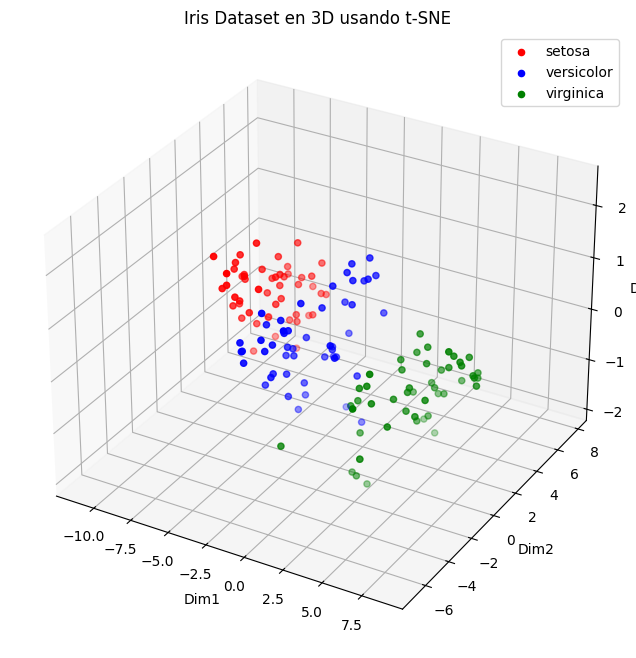

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.614047
Costo tras epoch 1000: 1.118353
Costo tras epoch 2000: 1.179090
Costo tras epoch 3000: 1.113974
Costo tras epoch 4000: 1.025278
Costo tras epoch 5000: 1.037277
Costo tras epoch 6000: 1.102014
Costo tras epoch 7000: 1.074662
Costo tras epoch 8000: 1.143944
Costo tras epoch 9000: 1.145592


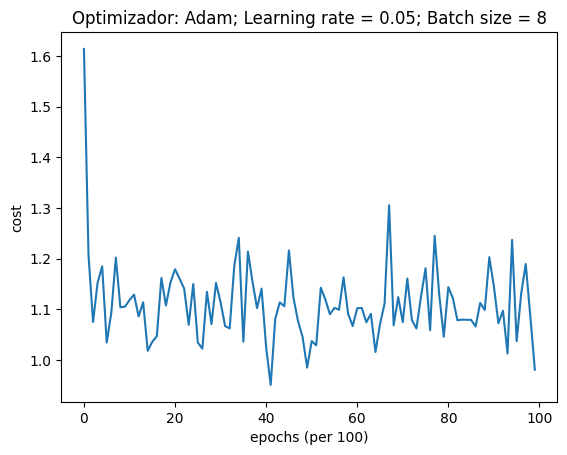

La exactitud para optimizador Adam con learning rate 0.05, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.450975
Costo tras epoch 1000: 1.149612
Costo tras epoch 2000: 1.067087
Costo tras epoch 3000: 1.152898
Costo tras epoch 4000: 1.202985
Costo tras epoch 5000: 1.095694
Costo tras epoch 6000: 1.045758
Costo tras epoch 7000: 1.010197
Costo tras epoch 8000: 1.159167
Costo tras epoch 9000: 1.095407


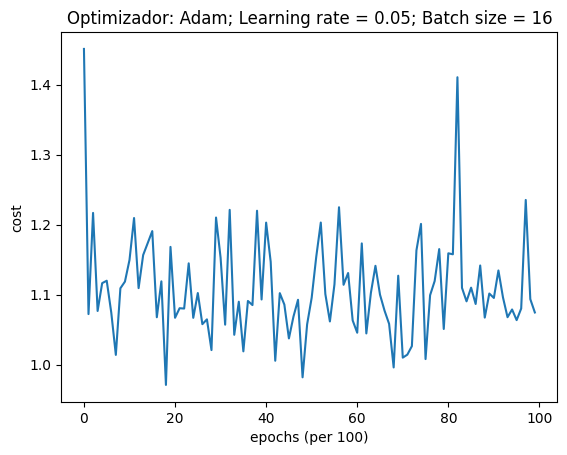

La exactitud para optimizador Adam con learning rate 0.05, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.175318
Costo tras epoch 1000: 1.129305
Costo tras epoch 2000: 1.083797
Costo tras epoch 3000: 1.092128
Costo tras epoch 4000: 1.072876
Costo tras epoch 5000: 1.069262
Costo tras epoch 6000: 1.108397
Costo tras epoch 7000: 1.099742
Costo tras epoch 8000: 1.120086
Costo tras epoch 9000: 1.101851


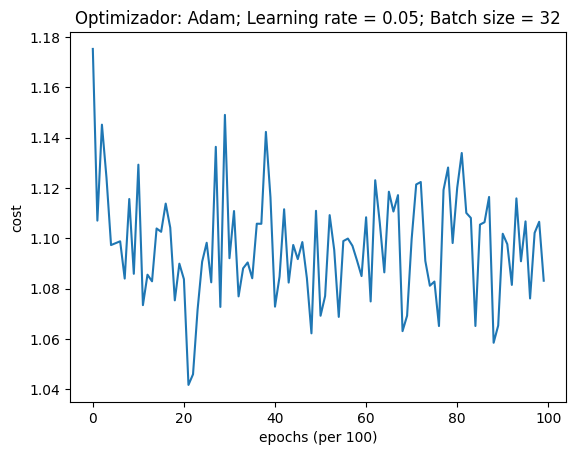

La exactitud para optimizador Adam con learning rate 0.05, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.625057
Costo tras epoch 1000: 1.040507
Costo tras epoch 2000: 1.039025
Costo tras epoch 3000: 1.062743
Costo tras epoch 4000: 1.108488
Costo tras epoch 5000: 1.035201
Costo tras epoch 6000: 1.111258
Costo tras epoch 7000: 1.024222
Costo tras epoch 8000: 1.105752
Costo tras epoch 9000: 1.058972


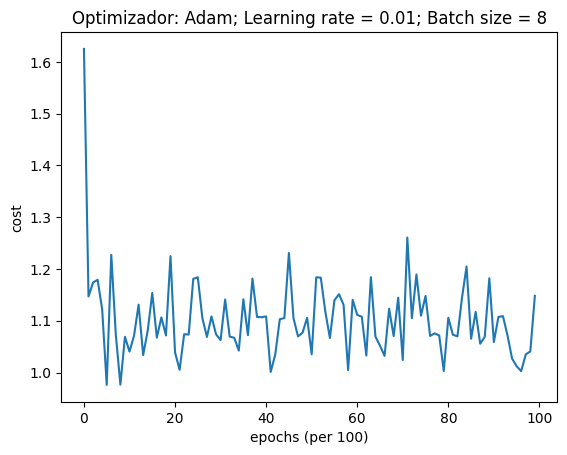

La exactitud para optimizador Adam con learning rate 0.01, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.233374
Costo tras epoch 1000: 0.000117
Costo tras epoch 2000: 0.000000
Costo tras epoch 3000: 0.000000
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: -0.000000
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: -0.000000


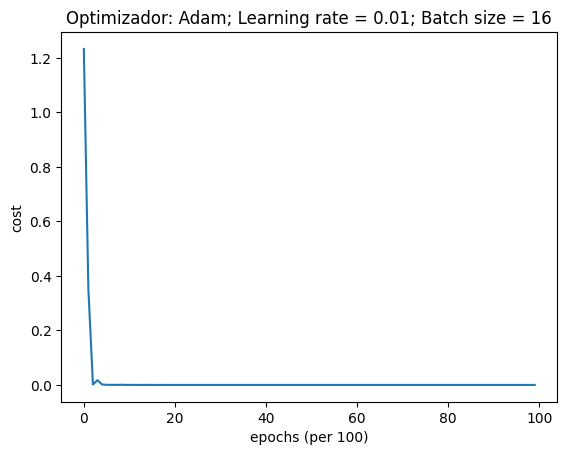

La exactitud para optimizador Adam con learning rate 0.01, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.256817
Costo tras epoch 1000: 1.098179
Costo tras epoch 2000: 1.092653
Costo tras epoch 3000: 1.083943
Costo tras epoch 4000: 1.119942
Costo tras epoch 5000: 1.092227
Costo tras epoch 6000: 1.084631
Costo tras epoch 7000: 1.105764
Costo tras epoch 8000: 1.140178
Costo tras epoch 9000: 1.052608


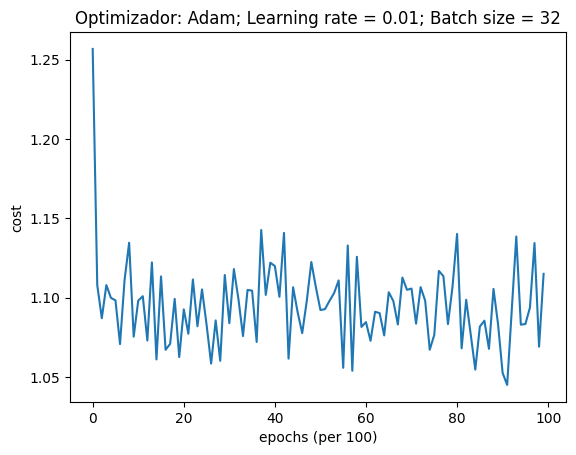

La exactitud para optimizador Adam con learning rate 0.01, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.216054
Costo tras epoch 1000: 1.041191
Costo tras epoch 2000: 1.101373
Costo tras epoch 3000: 1.142217
Costo tras epoch 4000: 1.069650
Costo tras epoch 5000: 1.071832
Costo tras epoch 6000: 1.007756
Costo tras epoch 7000: 1.070547
Costo tras epoch 8000: 1.034848
Costo tras epoch 9000: 1.004259


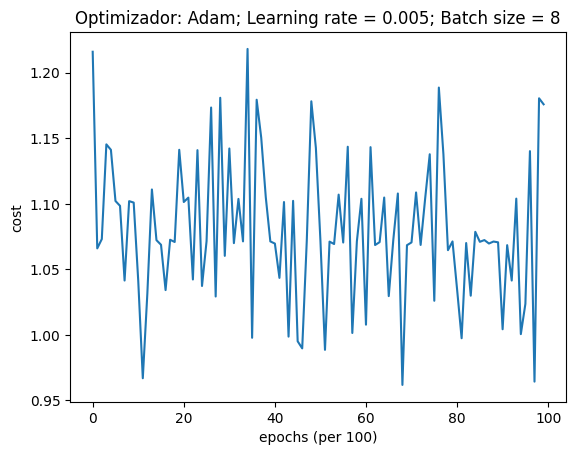

La exactitud para optimizador Adam con learning rate 0.005, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.137645
Costo tras epoch 1000: 1.144050
Costo tras epoch 2000: 1.060321
Costo tras epoch 3000: 1.111806
Costo tras epoch 4000: 0.967582
Costo tras epoch 5000: 1.134694
Costo tras epoch 6000: 1.071939
Costo tras epoch 7000: 1.072796
Costo tras epoch 8000: 1.070991
Costo tras epoch 9000: 1.100629


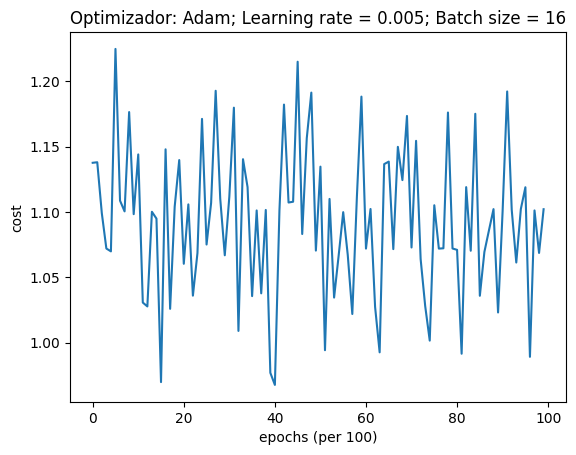

La exactitud para optimizador Adam con learning rate 0.005, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.125542
Costo tras epoch 1000: 0.549193
Costo tras epoch 2000: 0.366342
Costo tras epoch 3000: 0.014204
Costo tras epoch 4000: 0.000419
Costo tras epoch 5000: 0.000114
Costo tras epoch 6000: 0.000032
Costo tras epoch 7000: 0.000008
Costo tras epoch 8000: 0.000003
Costo tras epoch 9000: 0.000003


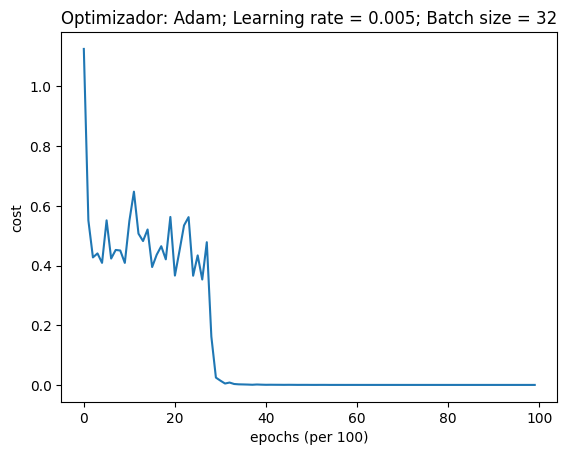

La exactitud para optimizador Adam con learning rate 0.005, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.117197
Costo tras epoch 1000: 0.000014
Costo tras epoch 2000: 0.000000
Costo tras epoch 3000: 0.000000
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: -0.000000
Costo tras epoch 9000: -0.000000


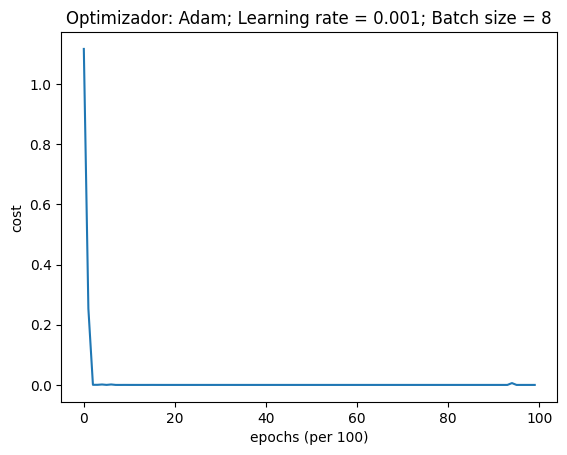

La exactitud para optimizador Adam con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.099451
Costo tras epoch 1000: 1.111336
Costo tras epoch 2000: 0.960086
Costo tras epoch 3000: 1.070950
Costo tras epoch 4000: 1.071210
Costo tras epoch 5000: 1.104687
Costo tras epoch 6000: 1.071393
Costo tras epoch 7000: 1.068215
Costo tras epoch 8000: 1.073584
Costo tras epoch 9000: 1.102686


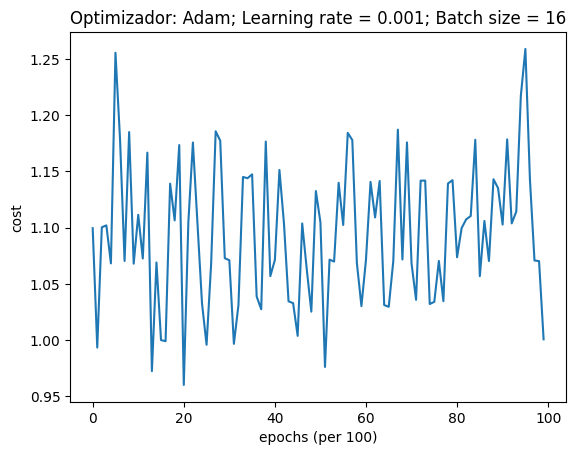

La exactitud para optimizador Adam con learning rate 0.001, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.091348
Costo tras epoch 1000: 0.003691
Costo tras epoch 2000: 0.000030
Costo tras epoch 3000: 0.000001
Costo tras epoch 4000: 0.000003
Costo tras epoch 5000: 0.000001
Costo tras epoch 6000: 0.000001
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: 0.000000


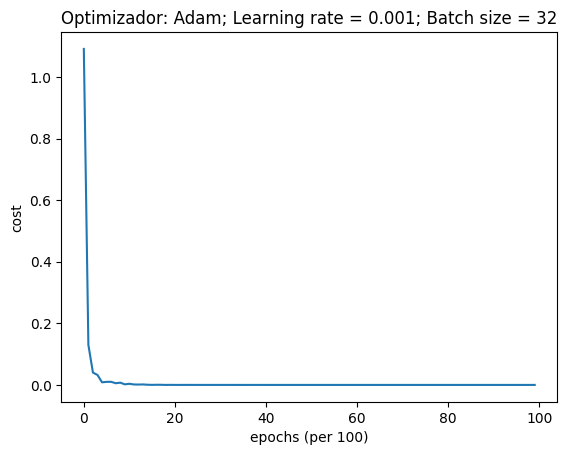

La exactitud para optimizador Adam con learning rate 0.001, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.101794
Costo tras epoch 1000: 0.000004
Costo tras epoch 2000: 0.000014
Costo tras epoch 3000: 0.000000
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: -0.000000
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000000


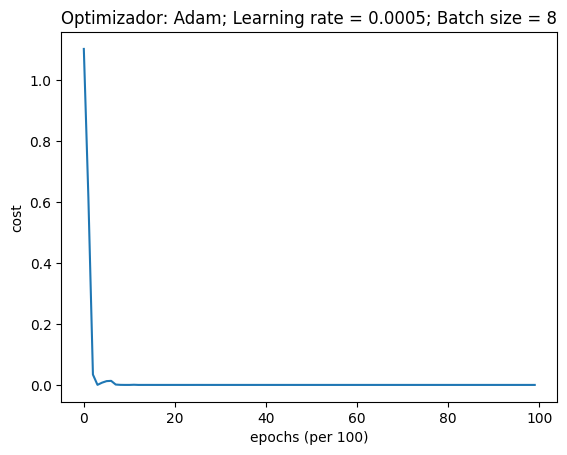

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.078073
Costo tras epoch 1000: 0.007326
Costo tras epoch 2000: 0.000456
Costo tras epoch 3000: 0.000029
Costo tras epoch 4000: 0.000000
Costo tras epoch 5000: 0.000001
Costo tras epoch 6000: 0.000006
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000003
Costo tras epoch 9000: 0.000000


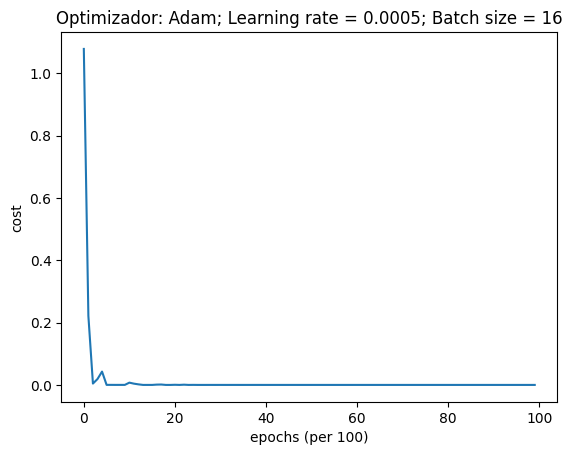

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.104879
Costo tras epoch 1000: 0.012600
Costo tras epoch 2000: 0.001970
Costo tras epoch 3000: 0.000063
Costo tras epoch 4000: 0.000022
Costo tras epoch 5000: 0.000002
Costo tras epoch 6000: 0.000004
Costo tras epoch 7000: 0.000001
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000001


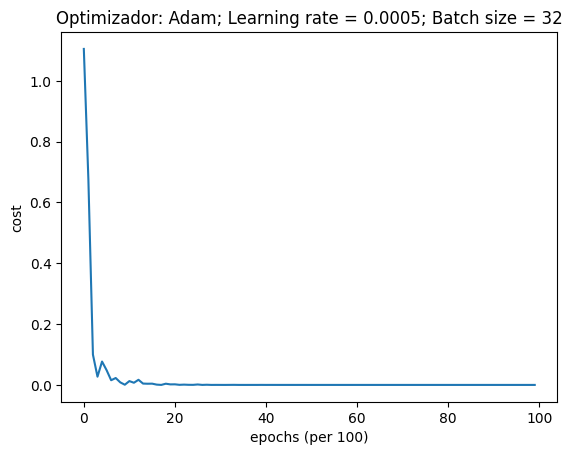

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.099308
Costo tras epoch 1000: 0.195111
Costo tras epoch 2000: 0.000040
Costo tras epoch 3000: 0.000704
Costo tras epoch 4000: 0.000001
Costo tras epoch 5000: -0.000000
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000000


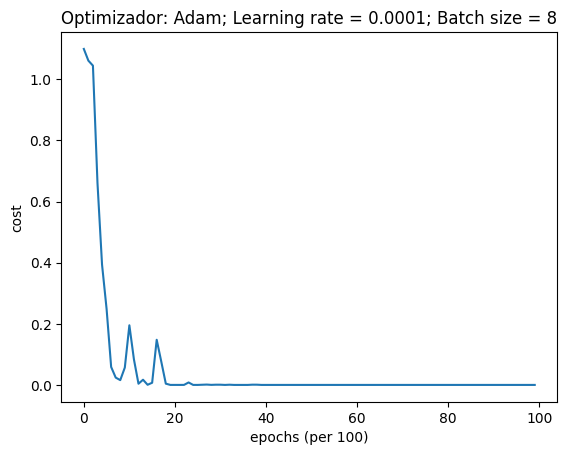

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.097658
Costo tras epoch 1000: 0.157107
Costo tras epoch 2000: 0.000787
Costo tras epoch 3000: 0.003765
Costo tras epoch 4000: 0.000086
Costo tras epoch 5000: 0.000378
Costo tras epoch 6000: 0.000007
Costo tras epoch 7000: 0.000013
Costo tras epoch 8000: 0.000709
Costo tras epoch 9000: 0.000003


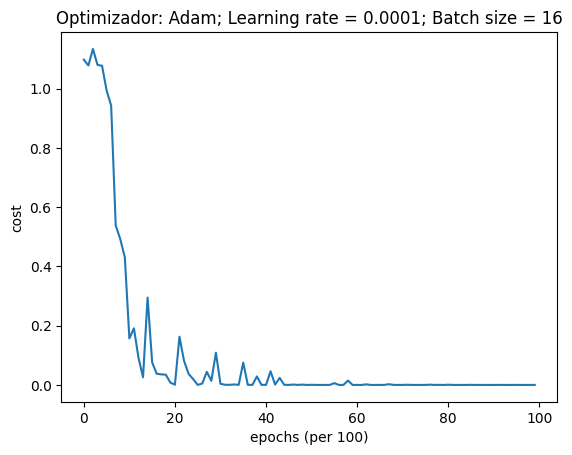

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098799
Costo tras epoch 1000: 0.487563
Costo tras epoch 2000: 0.102596
Costo tras epoch 3000: 0.039252
Costo tras epoch 4000: 0.007064
Costo tras epoch 5000: 0.000135
Costo tras epoch 6000: 0.002425
Costo tras epoch 7000: 0.000097
Costo tras epoch 8000: 0.000237
Costo tras epoch 9000: 0.000221


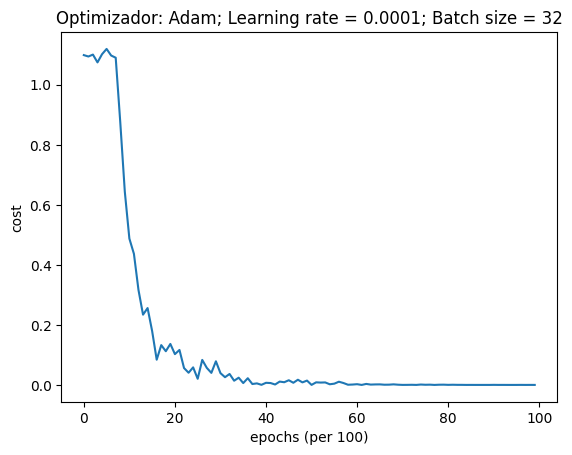

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.099652
Costo tras epoch 1000: 1.071626
Costo tras epoch 2000: 1.105366
Costo tras epoch 3000: 1.175482
Costo tras epoch 4000: 1.030584
Costo tras epoch 5000: 1.214632
Costo tras epoch 6000: 1.040555
Costo tras epoch 7000: 1.101016
Costo tras epoch 8000: 1.102768
Costo tras epoch 9000: 1.193936


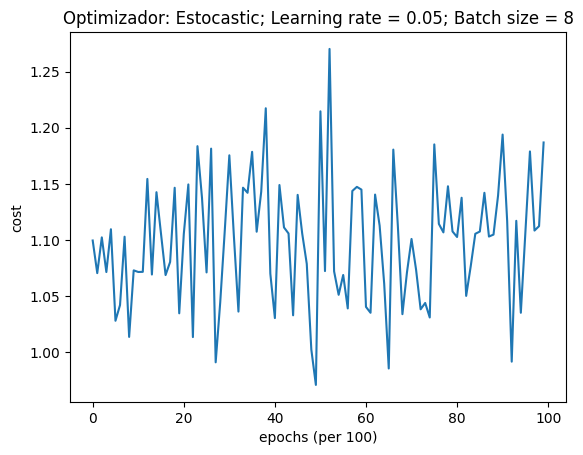

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.102174
Costo tras epoch 1000: 1.112130
Costo tras epoch 2000: 1.115227
Costo tras epoch 3000: 1.041077
Costo tras epoch 4000: 1.107512
Costo tras epoch 5000: 1.097600
Costo tras epoch 6000: 1.106617
Costo tras epoch 7000: 1.020105
Costo tras epoch 8000: 1.075763
Costo tras epoch 9000: 1.099712


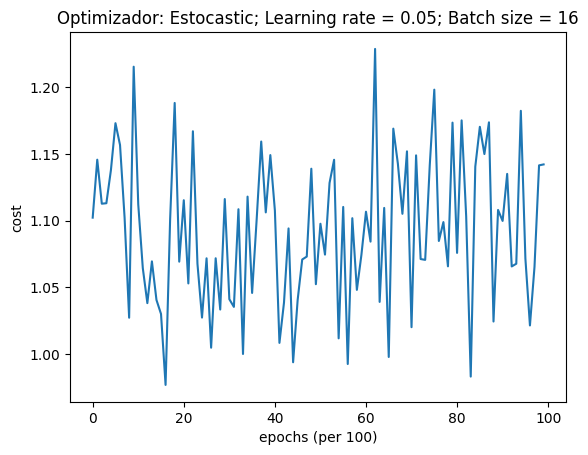

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.099301
Costo tras epoch 1000: 1.070866
Costo tras epoch 2000: 1.121019
Costo tras epoch 3000: 1.128560
Costo tras epoch 4000: 1.097953
Costo tras epoch 5000: 1.123616
Costo tras epoch 6000: 1.099468
Costo tras epoch 7000: 1.083570
Costo tras epoch 8000: 0.054028
Costo tras epoch 9000: 0.014303


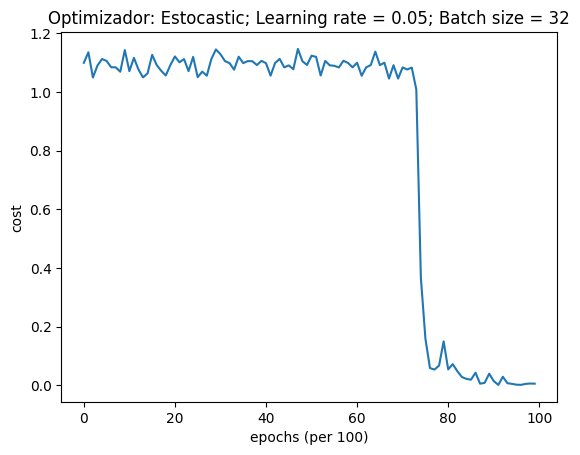

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098845
Costo tras epoch 1000: 0.997553
Costo tras epoch 2000: 1.106032
Costo tras epoch 3000: 1.001431
Costo tras epoch 4000: 1.037872
Costo tras epoch 5000: 1.104132
Costo tras epoch 6000: 1.104620
Costo tras epoch 7000: 1.142564
Costo tras epoch 8000: 1.034104
Costo tras epoch 9000: 1.104546


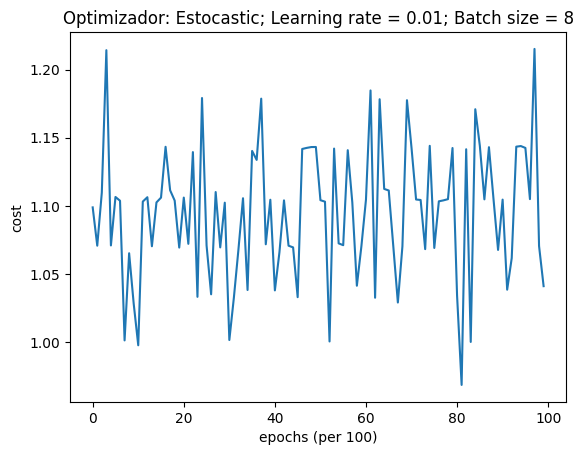

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.099023
Costo tras epoch 1000: 1.074973
Costo tras epoch 2000: 1.107054
Costo tras epoch 3000: 0.967213
Costo tras epoch 4000: 1.145195
Costo tras epoch 5000: 1.068964
Costo tras epoch 6000: 1.175033
Costo tras epoch 7000: 1.104505
Costo tras epoch 8000: 1.132116
Costo tras epoch 9000: 0.971017


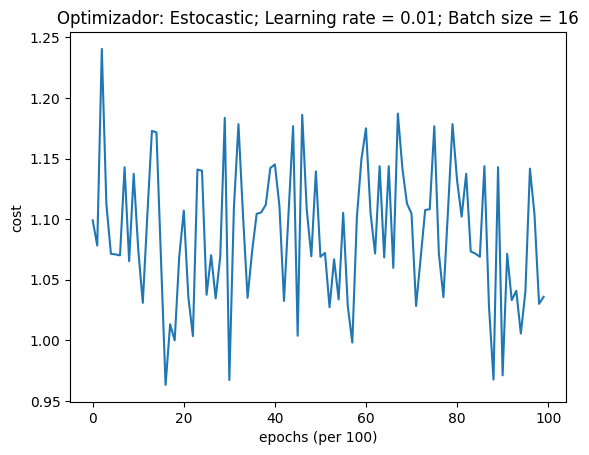

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098810
Costo tras epoch 1000: 1.077277
Costo tras epoch 2000: 1.063109
Costo tras epoch 3000: 1.063432
Costo tras epoch 4000: 1.083714
Costo tras epoch 5000: 1.134897
Costo tras epoch 6000: 1.076878
Costo tras epoch 7000: 1.084613
Costo tras epoch 8000: 1.147611
Costo tras epoch 9000: 1.083743


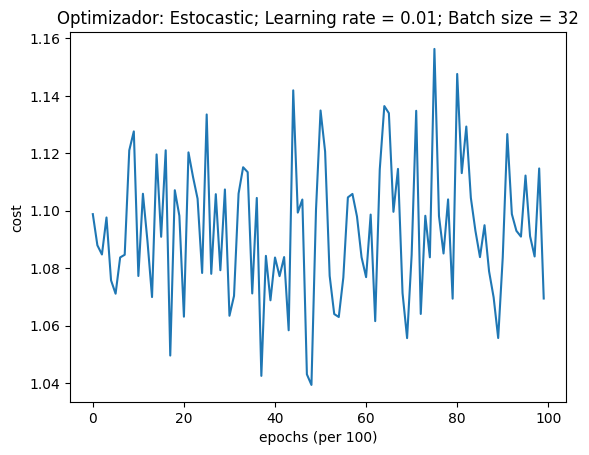

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.097471
Costo tras epoch 1000: 1.180630
Costo tras epoch 2000: 1.215400
Costo tras epoch 3000: 1.108843
Costo tras epoch 4000: 1.070986
Costo tras epoch 5000: 1.071911
Costo tras epoch 6000: 1.140931
Costo tras epoch 7000: 1.033000
Costo tras epoch 8000: 1.103619
Costo tras epoch 9000: 1.174173


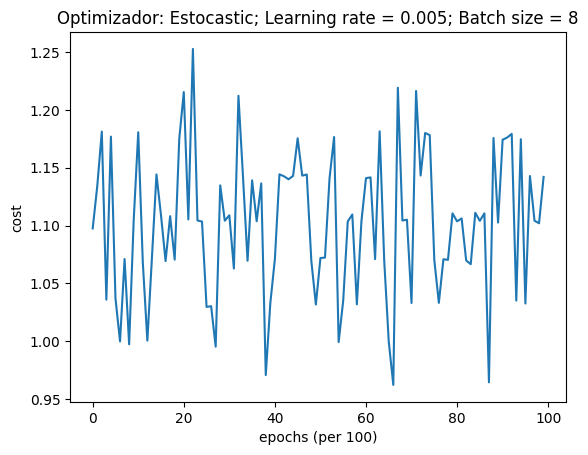

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098820
Costo tras epoch 1000: 1.174529
Costo tras epoch 2000: 1.178303
Costo tras epoch 3000: 1.175487
Costo tras epoch 4000: 1.140565
Costo tras epoch 5000: 1.182994
Costo tras epoch 6000: 1.176766
Costo tras epoch 7000: 1.068205
Costo tras epoch 8000: 0.999678
Costo tras epoch 9000: 1.107532


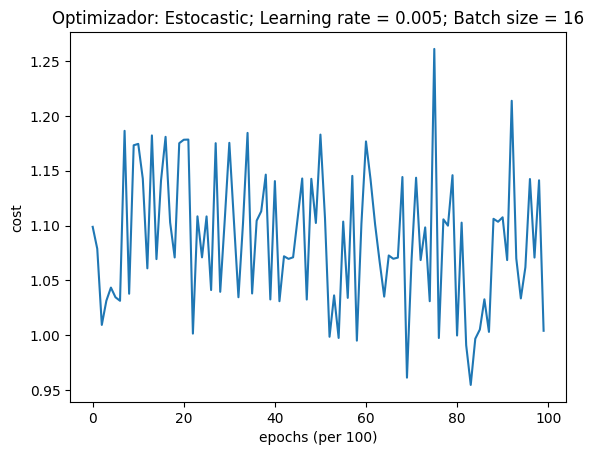

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098618
Costo tras epoch 1000: 1.069830
Costo tras epoch 2000: 1.107710
Costo tras epoch 3000: 1.112466
Costo tras epoch 4000: 1.083876
Costo tras epoch 5000: 1.106868
Costo tras epoch 6000: 1.124975
Costo tras epoch 7000: 1.112821
Costo tras epoch 8000: 1.063821
Costo tras epoch 9000: 1.098144


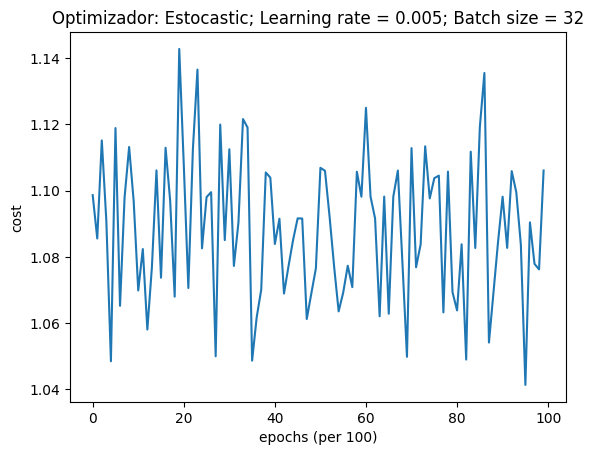

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098758
Costo tras epoch 1000: 1.070726
Costo tras epoch 2000: 0.999017
Costo tras epoch 3000: 0.964753
Costo tras epoch 4000: 1.136685
Costo tras epoch 5000: 1.108857
Costo tras epoch 6000: 1.252139
Costo tras epoch 7000: 0.999265
Costo tras epoch 8000: 1.070289
Costo tras epoch 9000: 1.137100


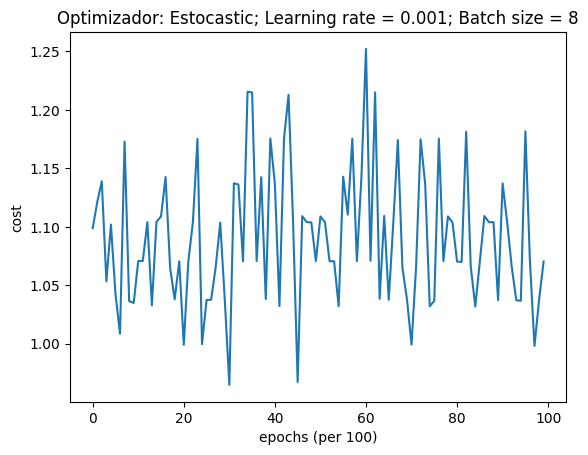

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098623
Costo tras epoch 1000: 1.072322
Costo tras epoch 2000: 1.140700
Costo tras epoch 3000: 1.110346
Costo tras epoch 4000: 1.141185
Costo tras epoch 5000: 1.069931
Costo tras epoch 6000: 1.070566
Costo tras epoch 7000: 1.070742
Costo tras epoch 8000: 1.065001
Costo tras epoch 9000: 1.103640


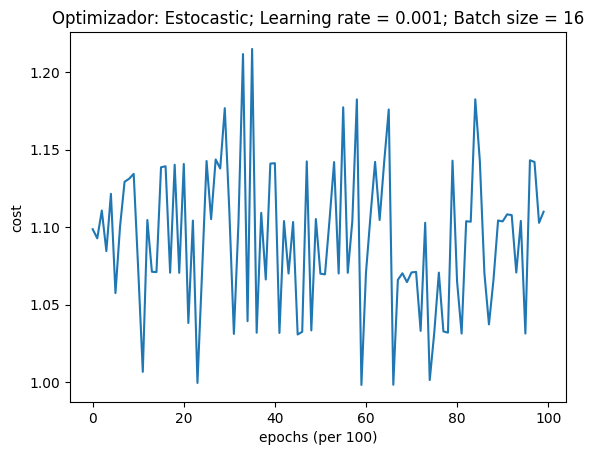

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098613
Costo tras epoch 1000: 1.087675
Costo tras epoch 2000: 1.091079
Costo tras epoch 3000: 1.084270
Costo tras epoch 4000: 1.112803
Costo tras epoch 5000: 1.120871
Costo tras epoch 6000: 1.091435
Costo tras epoch 7000: 1.083749
Costo tras epoch 8000: 1.069302
Costo tras epoch 9000: 1.135615


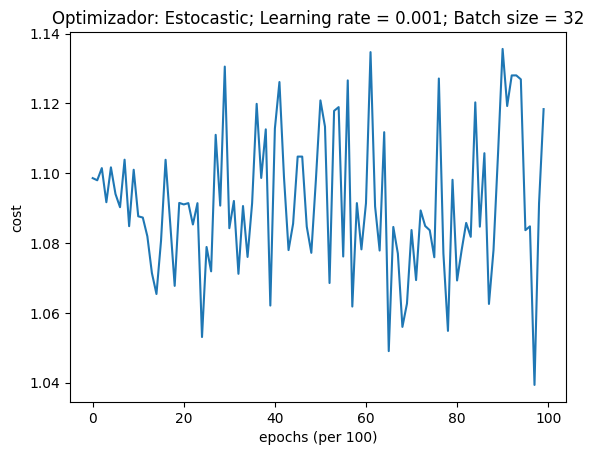

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098623
Costo tras epoch 1000: 1.073603
Costo tras epoch 2000: 1.038662
Costo tras epoch 3000: 1.141514
Costo tras epoch 4000: 1.103713
Costo tras epoch 5000: 1.175464
Costo tras epoch 6000: 1.109971
Costo tras epoch 7000: 1.103798
Costo tras epoch 8000: 1.103719
Costo tras epoch 9000: 1.142286


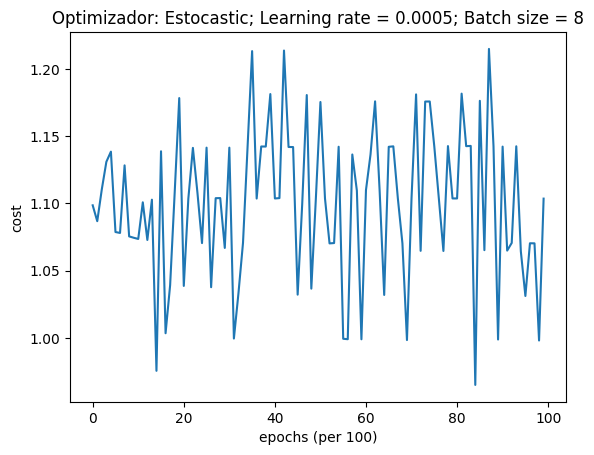

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098617
Costo tras epoch 1000: 1.078720
Costo tras epoch 2000: 1.104194
Costo tras epoch 3000: 1.070313
Costo tras epoch 4000: 1.069767
Costo tras epoch 5000: 1.142518
Costo tras epoch 6000: 1.142784
Costo tras epoch 7000: 1.103635
Costo tras epoch 8000: 1.108734
Costo tras epoch 9000: 1.143057


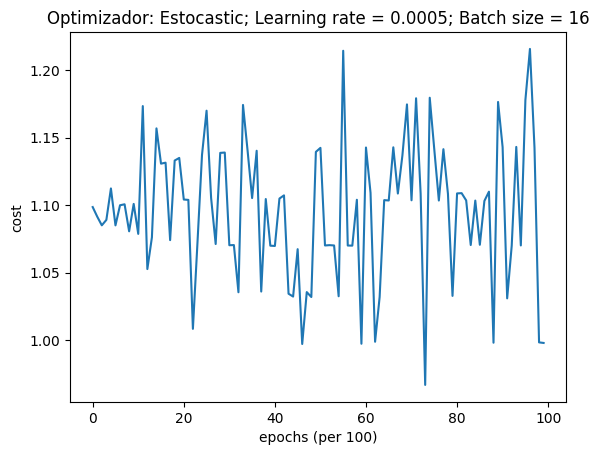

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098616
Costo tras epoch 1000: 1.099759
Costo tras epoch 2000: 1.087874
Costo tras epoch 3000: 1.086021
Costo tras epoch 4000: 1.054971
Costo tras epoch 5000: 1.051990
Costo tras epoch 6000: 1.105016
Costo tras epoch 7000: 1.070125
Costo tras epoch 8000: 1.048327
Costo tras epoch 9000: 1.054710


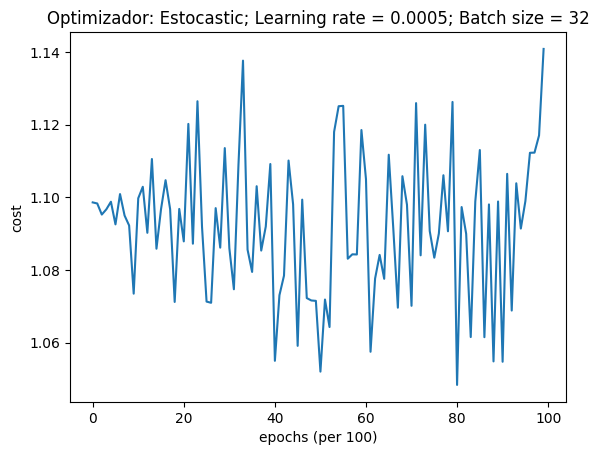

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098627
Costo tras epoch 1000: 1.066205
Costo tras epoch 2000: 1.082035
Costo tras epoch 3000: 1.125581
Costo tras epoch 4000: 1.047125
Costo tras epoch 5000: 1.073724
Costo tras epoch 6000: 1.041929
Costo tras epoch 7000: 1.138014
Costo tras epoch 8000: 1.003624
Costo tras epoch 9000: 1.034261


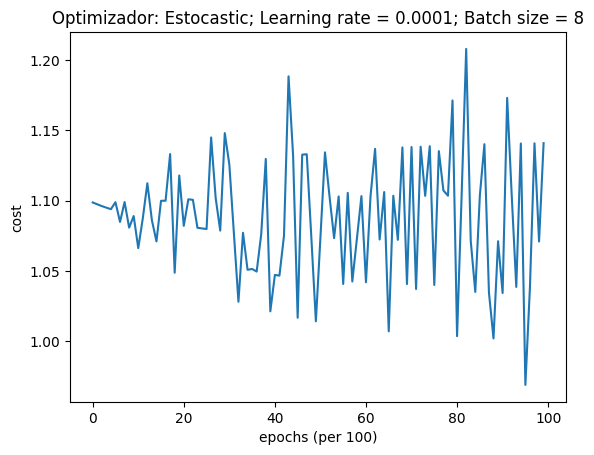

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 8 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098607
Costo tras epoch 1000: 1.105463
Costo tras epoch 2000: 1.099366
Costo tras epoch 3000: 1.100263
Costo tras epoch 4000: 1.080964
Costo tras epoch 5000: 1.101218
Costo tras epoch 6000: 1.026926
Costo tras epoch 7000: 1.103338
Costo tras epoch 8000: 1.102454
Costo tras epoch 9000: 1.042713


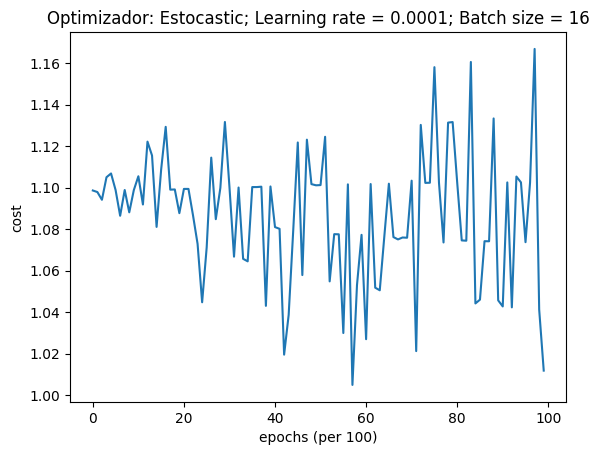

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 16 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 12, 8, 3)
Costo tras epoch 0: 1.098612
Costo tras epoch 1000: 1.097361
Costo tras epoch 2000: 1.087050
Costo tras epoch 3000: 1.087918
Costo tras epoch 4000: 1.104103
Costo tras epoch 5000: 1.091225
Costo tras epoch 6000: 1.096791
Costo tras epoch 7000: 1.100360
Costo tras epoch 8000: 1.124399
Costo tras epoch 9000: 1.109418


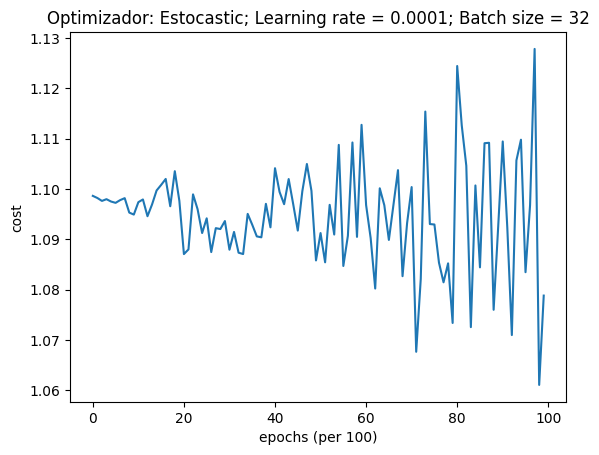

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 32 y estructura de capas (4, 16, 12, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 0.811984
Costo tras epoch 1000: 1.076827
Costo tras epoch 2000: 1.093069
Costo tras epoch 3000: 1.063950
Costo tras epoch 4000: 1.108576
Costo tras epoch 5000: 1.110546
Costo tras epoch 6000: 1.066537
Costo tras epoch 7000: 1.017924
Costo tras epoch 8000: 1.127155
Costo tras epoch 9000: 1.017060


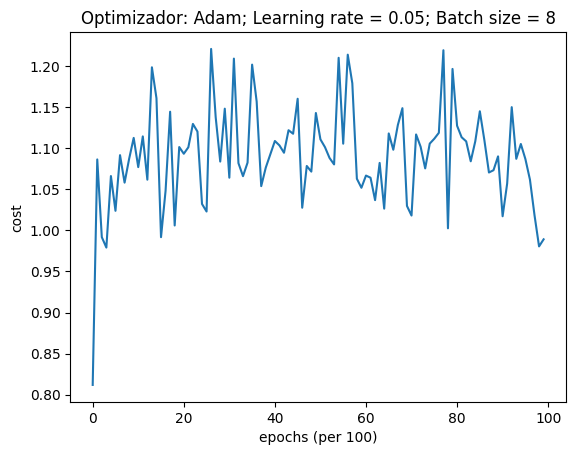

La exactitud para optimizador Adam con learning rate 0.05, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.093283
Costo tras epoch 1000: 1.151748
Costo tras epoch 2000: 1.065502
Costo tras epoch 3000: 1.124663
Costo tras epoch 4000: 1.095670
Costo tras epoch 5000: 1.141347
Costo tras epoch 6000: 1.027260
Costo tras epoch 7000: 1.156011
Costo tras epoch 8000: 1.032718
Costo tras epoch 9000: 1.098236


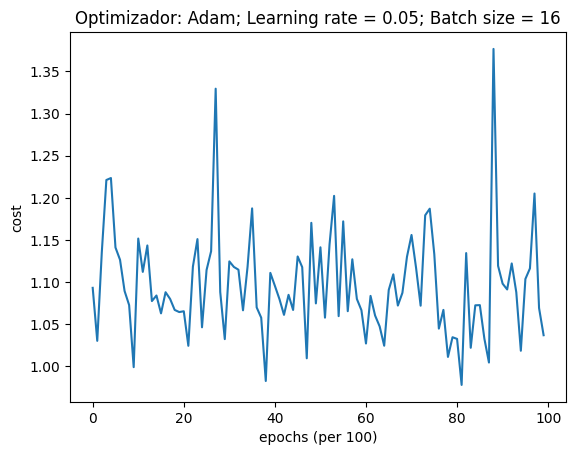

La exactitud para optimizador Adam con learning rate 0.05, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 8.047961
Costo tras epoch 1000: 1.098371
Costo tras epoch 2000: 1.102744
Costo tras epoch 3000: 1.085346
Costo tras epoch 4000: 1.120169
Costo tras epoch 5000: 1.127242
Costo tras epoch 6000: 1.075853
Costo tras epoch 7000: 1.083658
Costo tras epoch 8000: 1.090081
Costo tras epoch 9000: 1.083984


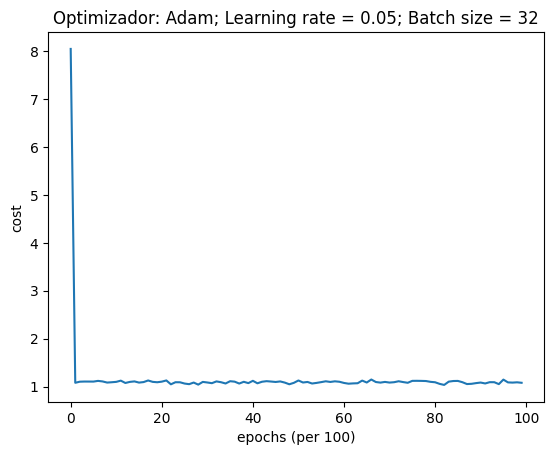

La exactitud para optimizador Adam con learning rate 0.05, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.014409
Costo tras epoch 1000: 1.185075
Costo tras epoch 2000: 1.073046
Costo tras epoch 3000: 1.173243
Costo tras epoch 4000: 1.110230
Costo tras epoch 5000: 0.990204
Costo tras epoch 6000: 1.069753
Costo tras epoch 7000: 1.072903
Costo tras epoch 8000: 1.071274
Costo tras epoch 9000: 1.137456


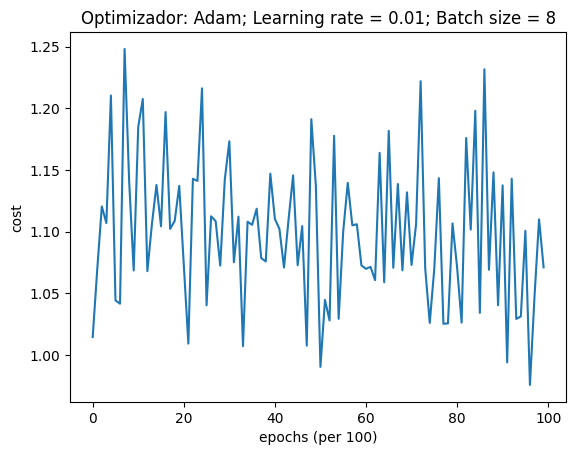

La exactitud para optimizador Adam con learning rate 0.01, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.068430
Costo tras epoch 1000: 1.070427
Costo tras epoch 2000: 1.105259
Costo tras epoch 3000: 1.072086
Costo tras epoch 4000: 1.255025
Costo tras epoch 5000: 1.097074
Costo tras epoch 6000: 1.070410
Costo tras epoch 7000: 1.067527
Costo tras epoch 8000: 1.204163
Costo tras epoch 9000: 1.070224


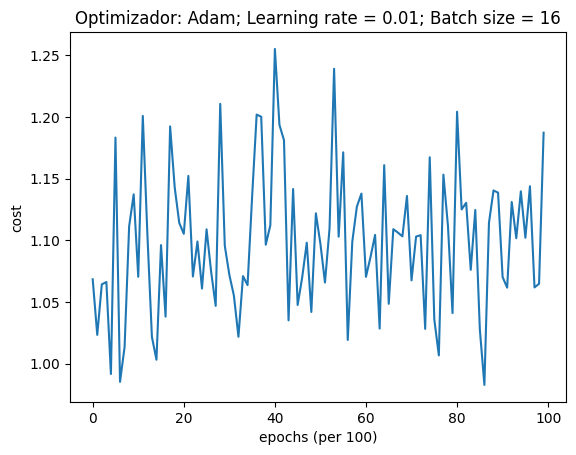

La exactitud para optimizador Adam con learning rate 0.01, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.145873
Costo tras epoch 1000: 1.089411
Costo tras epoch 2000: 1.110838
Costo tras epoch 3000: 1.084816
Costo tras epoch 4000: 1.114682
Costo tras epoch 5000: 1.070765
Costo tras epoch 6000: 1.106748
Costo tras epoch 7000: 1.094659
Costo tras epoch 8000: 1.083662
Costo tras epoch 9000: 1.075589


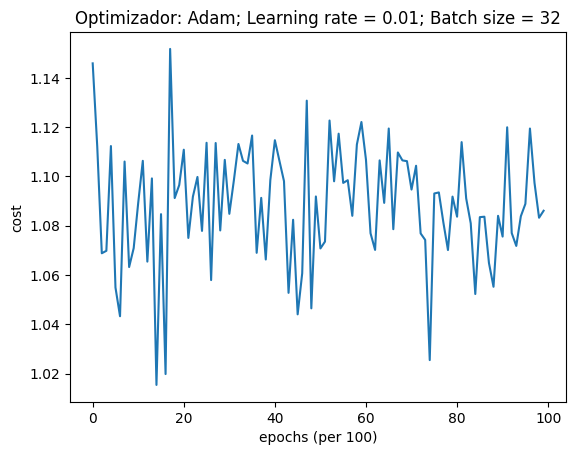

La exactitud para optimizador Adam con learning rate 0.01, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.130659
Costo tras epoch 1000: 1.113593
Costo tras epoch 2000: 0.966575
Costo tras epoch 3000: 1.145673
Costo tras epoch 4000: 1.100576
Costo tras epoch 5000: 1.106597
Costo tras epoch 6000: 1.102184
Costo tras epoch 7000: 1.139084
Costo tras epoch 8000: 1.069823
Costo tras epoch 9000: 0.997838


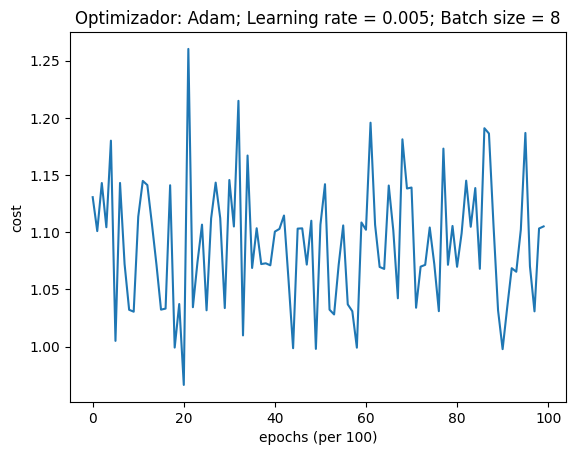

La exactitud para optimizador Adam con learning rate 0.005, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.163577
Costo tras epoch 1000: 0.013074
Costo tras epoch 2000: 0.000847
Costo tras epoch 3000: 0.000059
Costo tras epoch 4000: 0.000019
Costo tras epoch 5000: 0.000010
Costo tras epoch 6000: 0.000026
Costo tras epoch 7000: 0.000002
Costo tras epoch 8000: 0.000004
Costo tras epoch 9000: 0.000004


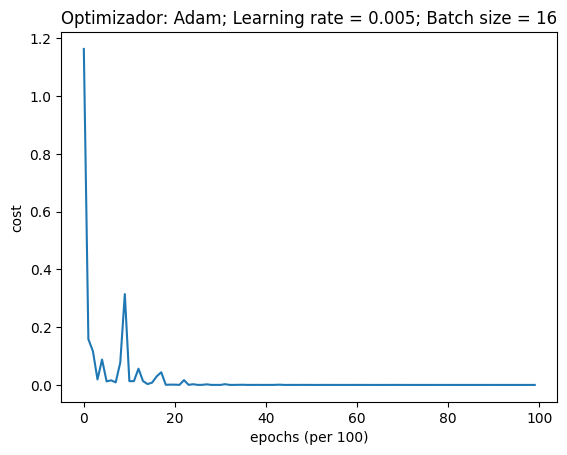

La exactitud para optimizador Adam con learning rate 0.005, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.103181
Costo tras epoch 1000: 0.379189
Costo tras epoch 2000: 0.492001
Costo tras epoch 3000: 0.420228
Costo tras epoch 4000: 0.491951
Costo tras epoch 5000: 0.450567
Costo tras epoch 6000: 0.407577
Costo tras epoch 7000: 0.394285
Costo tras epoch 8000: 0.448676
Costo tras epoch 9000: 0.463559


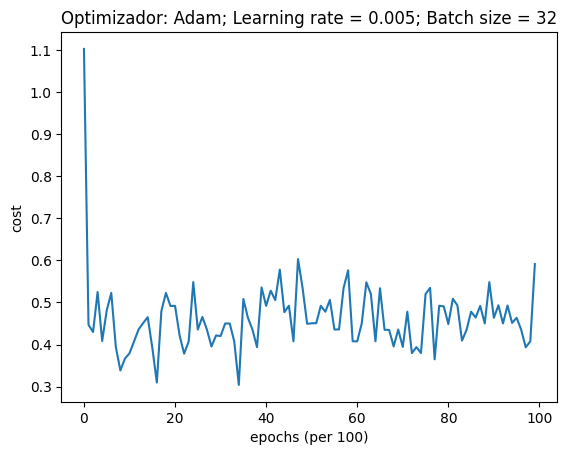

La exactitud para optimizador Adam con learning rate 0.005, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 66.666667 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.093045
Costo tras epoch 1000: 0.016664
Costo tras epoch 2000: 0.000055
Costo tras epoch 3000: 0.000019
Costo tras epoch 4000: 0.000008
Costo tras epoch 5000: 0.000005
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000002
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000002


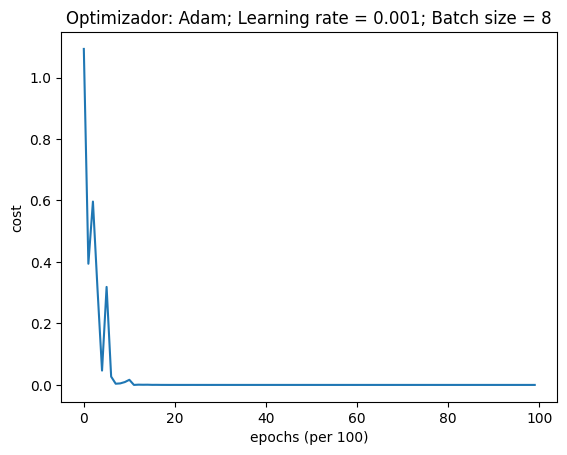

La exactitud para optimizador Adam con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.092922
Costo tras epoch 1000: 0.000082
Costo tras epoch 2000: 0.000010
Costo tras epoch 3000: 0.000001
Costo tras epoch 4000: 0.000001
Costo tras epoch 5000: 0.000047
Costo tras epoch 6000: 0.000007
Costo tras epoch 7000: 0.000025
Costo tras epoch 8000: 0.000010
Costo tras epoch 9000: 0.000000


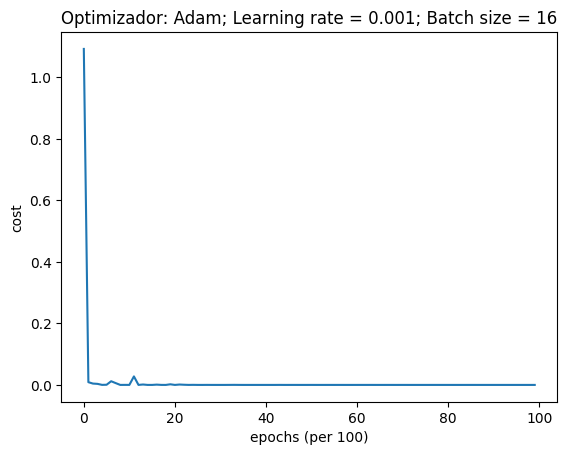

La exactitud para optimizador Adam con learning rate 0.001, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.101275
Costo tras epoch 1000: 0.004836
Costo tras epoch 2000: 0.000082
Costo tras epoch 3000: 0.000486
Costo tras epoch 4000: 0.000078
Costo tras epoch 5000: 0.000005
Costo tras epoch 6000: 0.000005
Costo tras epoch 7000: 0.000002
Costo tras epoch 8000: 0.000002
Costo tras epoch 9000: 0.000001


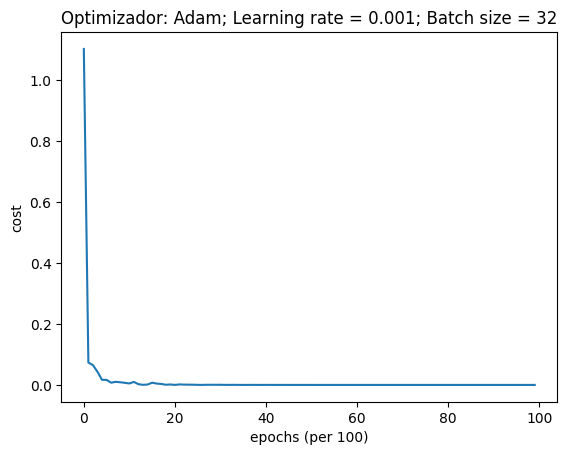

La exactitud para optimizador Adam con learning rate 0.001, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.101824
Costo tras epoch 1000: 0.002123
Costo tras epoch 2000: 0.000018
Costo tras epoch 3000: 0.000001
Costo tras epoch 4000: 0.000001
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: -0.000000
Costo tras epoch 7000: -0.000000
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000000


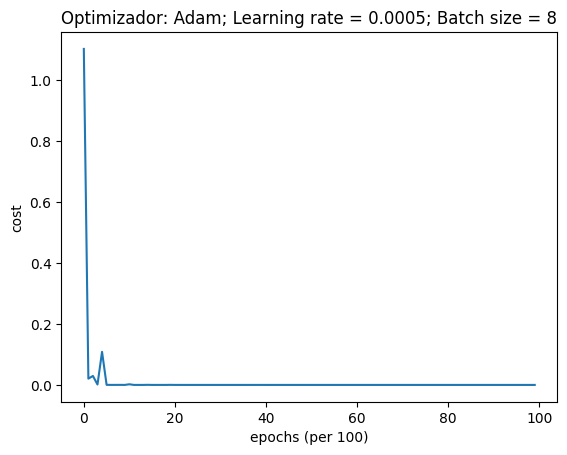

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.089940
Costo tras epoch 1000: 1.070561
Costo tras epoch 2000: 1.091797
Costo tras epoch 3000: 1.071953
Costo tras epoch 4000: 1.102990
Costo tras epoch 5000: 1.070641
Costo tras epoch 6000: 1.211607
Costo tras epoch 7000: 1.104503
Costo tras epoch 8000: 1.104087
Costo tras epoch 9000: 1.103684


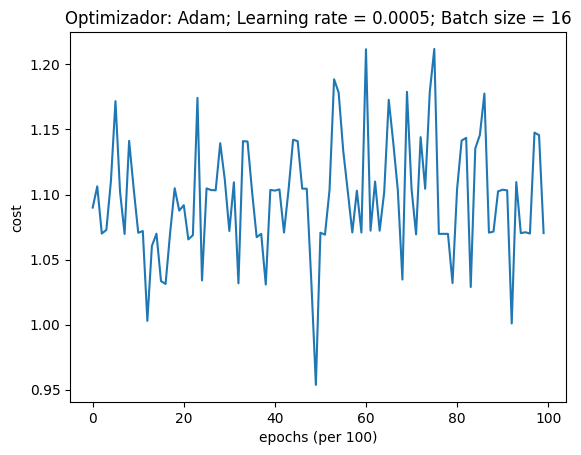

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.096241
Costo tras epoch 1000: 0.009663
Costo tras epoch 2000: 0.017398
Costo tras epoch 3000: 0.008134
Costo tras epoch 4000: 0.001207
Costo tras epoch 5000: 0.000506
Costo tras epoch 6000: 0.000084
Costo tras epoch 7000: 0.000026
Costo tras epoch 8000: 0.000010
Costo tras epoch 9000: 0.000005


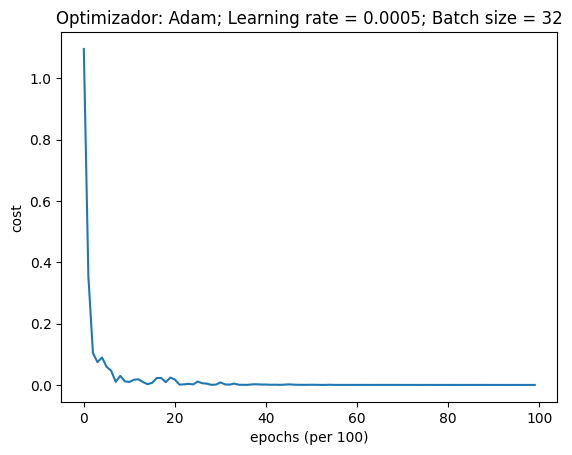

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098544
Costo tras epoch 1000: 0.017887
Costo tras epoch 2000: 0.010078
Costo tras epoch 3000: 0.000029
Costo tras epoch 4000: 0.000551
Costo tras epoch 5000: 0.000044
Costo tras epoch 6000: 0.000001
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: 0.000022


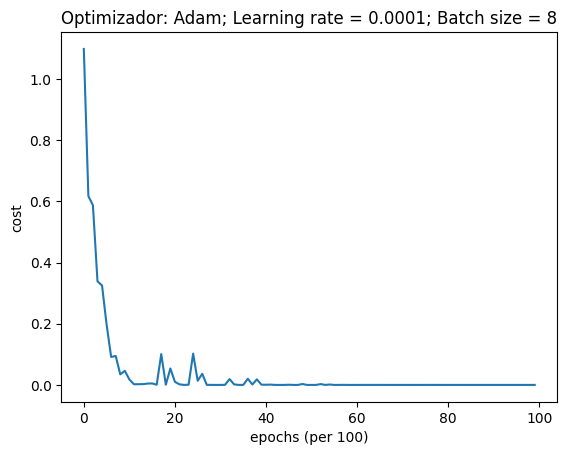

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098260
Costo tras epoch 1000: 0.587830
Costo tras epoch 2000: 0.873539
Costo tras epoch 3000: 0.682325
Costo tras epoch 4000: 0.366776
Costo tras epoch 5000: 0.650626
Costo tras epoch 6000: 0.498290
Costo tras epoch 7000: 0.354730
Costo tras epoch 8000: 0.327686
Costo tras epoch 9000: 0.208655


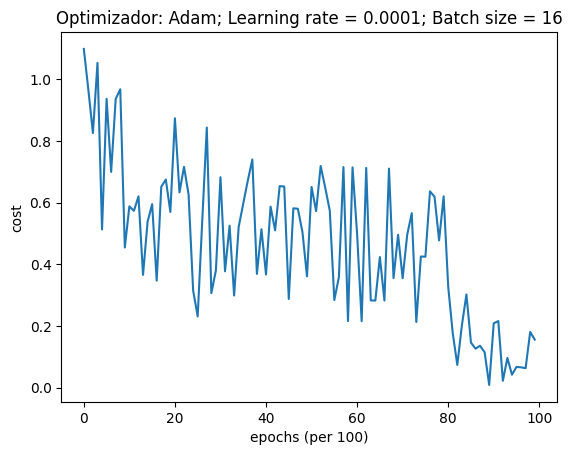

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.099143
Costo tras epoch 1000: 0.436634
Costo tras epoch 2000: 0.109508
Costo tras epoch 3000: 0.143331
Costo tras epoch 4000: 0.090397
Costo tras epoch 5000: 0.062608
Costo tras epoch 6000: 0.065783
Costo tras epoch 7000: 0.004641
Costo tras epoch 8000: 0.010232
Costo tras epoch 9000: 0.001653


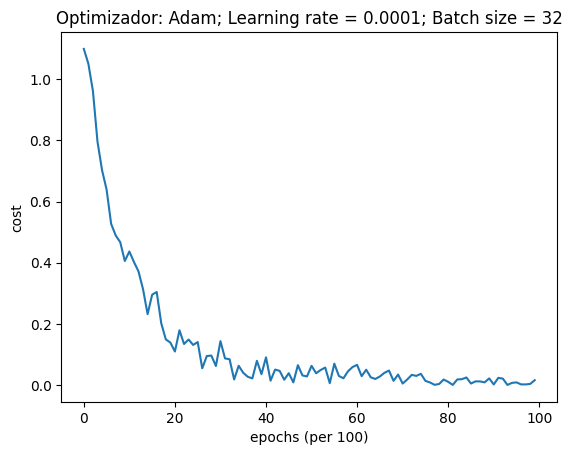

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.090787
Costo tras epoch 1000: 0.001760
Costo tras epoch 2000: 0.000085
Costo tras epoch 3000: 0.000014
Costo tras epoch 4000: 0.000028
Costo tras epoch 5000: 0.000021
Costo tras epoch 6000: 0.000004
Costo tras epoch 7000: 0.000197
Costo tras epoch 8000: 0.000002
Costo tras epoch 9000: 0.000037


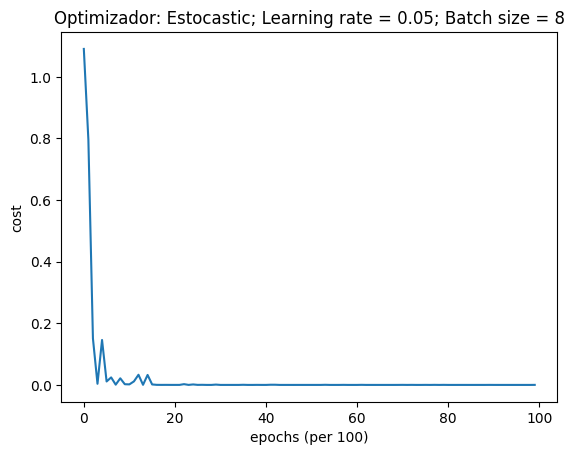

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.096075
Costo tras epoch 1000: 0.000797
Costo tras epoch 2000: 0.006582
Costo tras epoch 3000: 0.000006
Costo tras epoch 4000: 0.001371
Costo tras epoch 5000: 0.000013
Costo tras epoch 6000: 0.000006
Costo tras epoch 7000: 0.000314
Costo tras epoch 8000: 0.000003
Costo tras epoch 9000: 0.000004


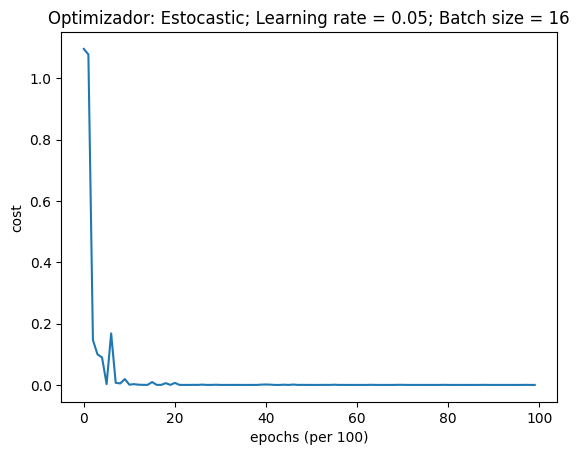

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098207
Costo tras epoch 1000: 0.048121
Costo tras epoch 2000: 0.037508
Costo tras epoch 3000: 0.031859
Costo tras epoch 4000: 0.006076
Costo tras epoch 5000: 0.003823
Costo tras epoch 6000: 0.003392
Costo tras epoch 7000: 0.000967
Costo tras epoch 8000: 0.000700
Costo tras epoch 9000: 0.000205


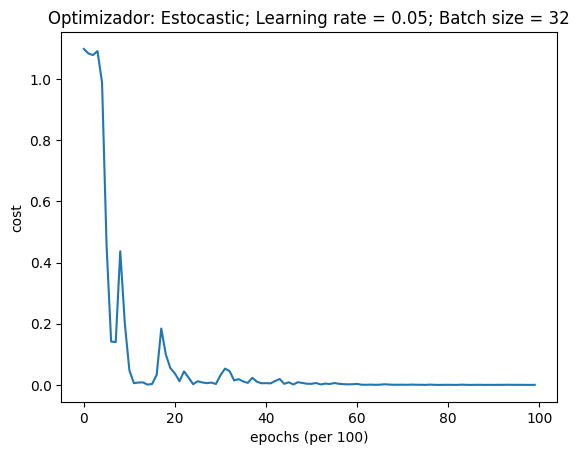

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.100070
Costo tras epoch 1000: 0.025104
Costo tras epoch 2000: 0.000165
Costo tras epoch 3000: 0.000112
Costo tras epoch 4000: 0.000053
Costo tras epoch 5000: 0.000013
Costo tras epoch 6000: 0.000085
Costo tras epoch 7000: 0.000012
Costo tras epoch 8000: 0.001529
Costo tras epoch 9000: 0.000006


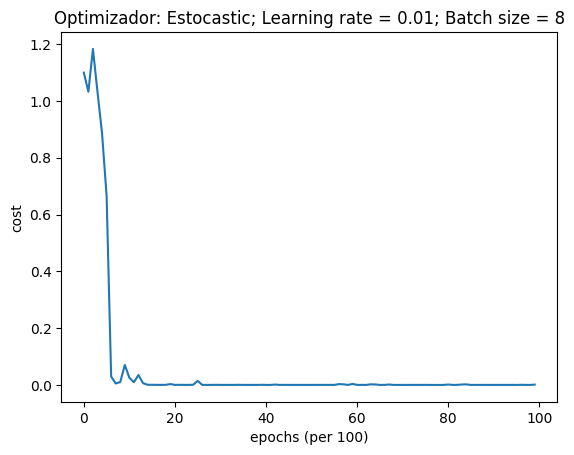

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.099332
Costo tras epoch 1000: 0.557757
Costo tras epoch 2000: 0.002642
Costo tras epoch 3000: 0.000279
Costo tras epoch 4000: 0.000068
Costo tras epoch 5000: 0.000498
Costo tras epoch 6000: 0.000563
Costo tras epoch 7000: 0.000155
Costo tras epoch 8000: 0.000335
Costo tras epoch 9000: 0.000354


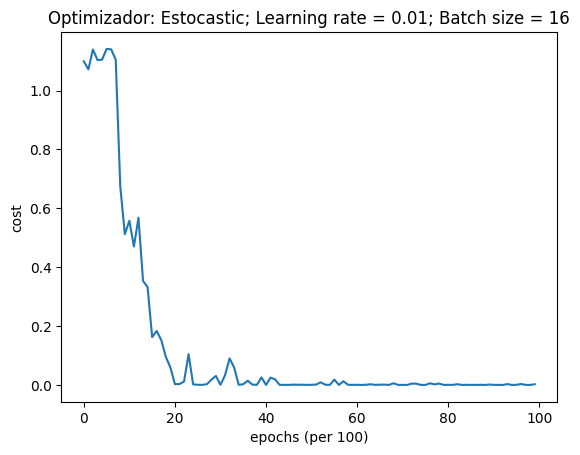

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098603
Costo tras epoch 1000: 1.110909
Costo tras epoch 2000: 0.160230
Costo tras epoch 3000: 0.014002
Costo tras epoch 4000: 0.002265
Costo tras epoch 5000: 0.010508
Costo tras epoch 6000: 0.003461
Costo tras epoch 7000: 0.000327
Costo tras epoch 8000: 0.003141
Costo tras epoch 9000: 0.002745


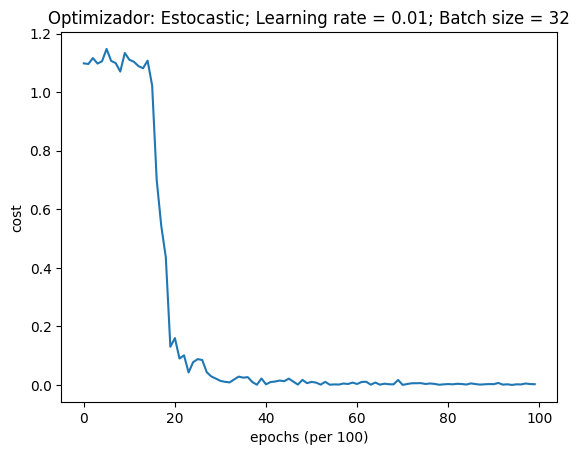

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098093
Costo tras epoch 1000: 0.346456
Costo tras epoch 2000: 0.103237
Costo tras epoch 3000: 0.048064
Costo tras epoch 4000: 0.033554
Costo tras epoch 5000: 0.025283
Costo tras epoch 6000: 0.020214
Costo tras epoch 7000: 0.025275
Costo tras epoch 8000: 0.010826
Costo tras epoch 9000: 0.044810


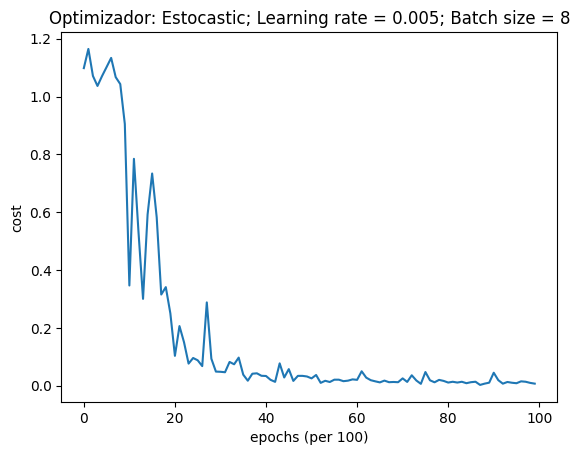

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.099905
Costo tras epoch 1000: 1.104324
Costo tras epoch 2000: 0.073657
Costo tras epoch 3000: 0.004636
Costo tras epoch 4000: 0.000379
Costo tras epoch 5000: 0.000292
Costo tras epoch 6000: 0.002460
Costo tras epoch 7000: 0.000171
Costo tras epoch 8000: 0.000092
Costo tras epoch 9000: 0.000026


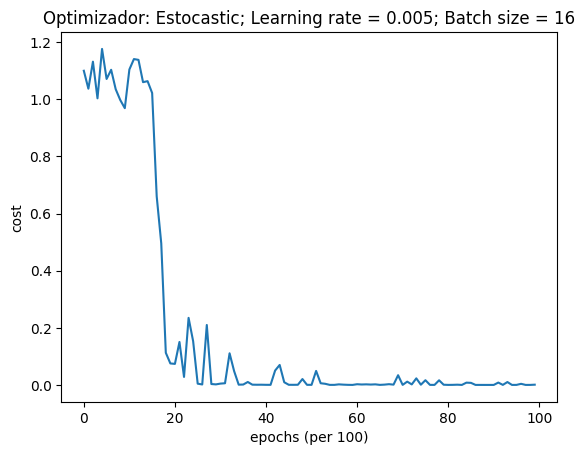

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098576
Costo tras epoch 1000: 1.098240
Costo tras epoch 2000: 1.098014
Costo tras epoch 3000: 1.103056
Costo tras epoch 4000: 0.243104
Costo tras epoch 5000: 0.058890
Costo tras epoch 6000: 0.049228
Costo tras epoch 7000: 0.016384
Costo tras epoch 8000: 0.022533
Costo tras epoch 9000: 0.010758


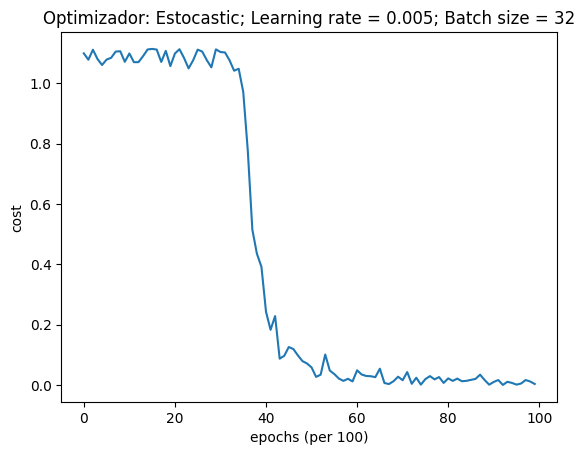

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098451
Costo tras epoch 1000: 1.067414
Costo tras epoch 2000: 0.999452
Costo tras epoch 3000: 1.096936
Costo tras epoch 4000: 1.032364
Costo tras epoch 5000: 1.103849
Costo tras epoch 6000: 1.139759
Costo tras epoch 7000: 0.285740
Costo tras epoch 8000: 0.300150
Costo tras epoch 9000: 0.204904


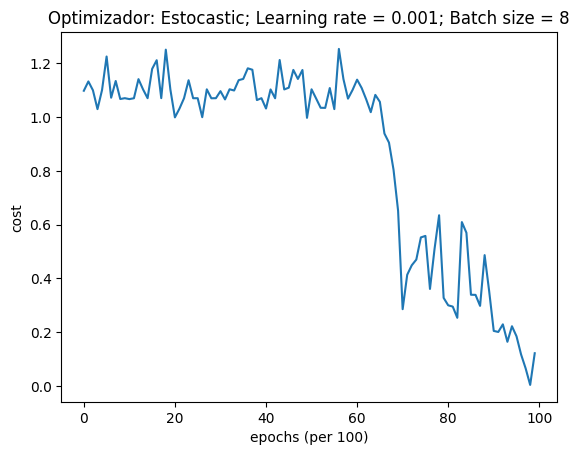

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 100.000000 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098684
Costo tras epoch 1000: 1.010114
Costo tras epoch 2000: 1.103996
Costo tras epoch 3000: 1.070449
Costo tras epoch 4000: 1.066076
Costo tras epoch 5000: 1.070570
Costo tras epoch 6000: 1.104293
Costo tras epoch 7000: 1.109968
Costo tras epoch 8000: 1.212541
Costo tras epoch 9000: 1.182060


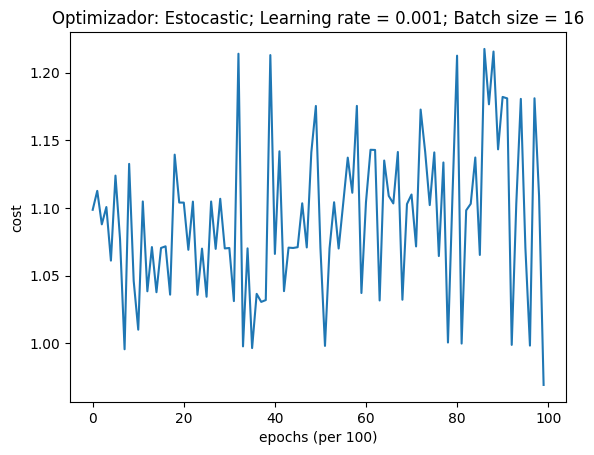

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098591
Costo tras epoch 1000: 1.092330
Costo tras epoch 2000: 1.048338
Costo tras epoch 3000: 1.091332
Costo tras epoch 4000: 1.148535
Costo tras epoch 5000: 1.091327
Costo tras epoch 6000: 1.097050
Costo tras epoch 7000: 1.069457
Costo tras epoch 8000: 1.068085
Costo tras epoch 9000: 1.104023


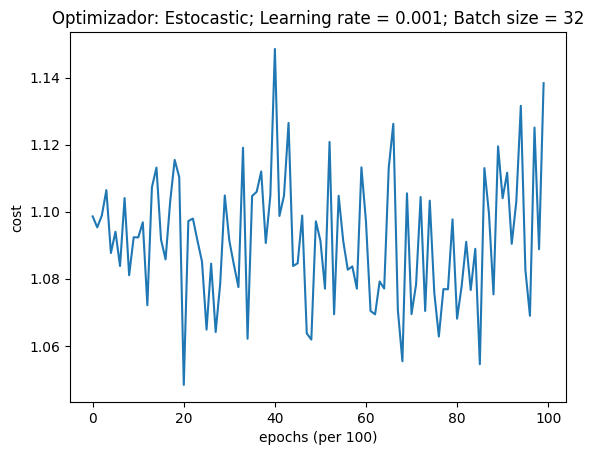

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098562
Costo tras epoch 1000: 1.073402
Costo tras epoch 2000: 1.065782
Costo tras epoch 3000: 1.175503
Costo tras epoch 4000: 1.142830
Costo tras epoch 5000: 1.138229
Costo tras epoch 6000: 1.037068
Costo tras epoch 7000: 1.142673
Costo tras epoch 8000: 1.037079
Costo tras epoch 9000: 1.070387


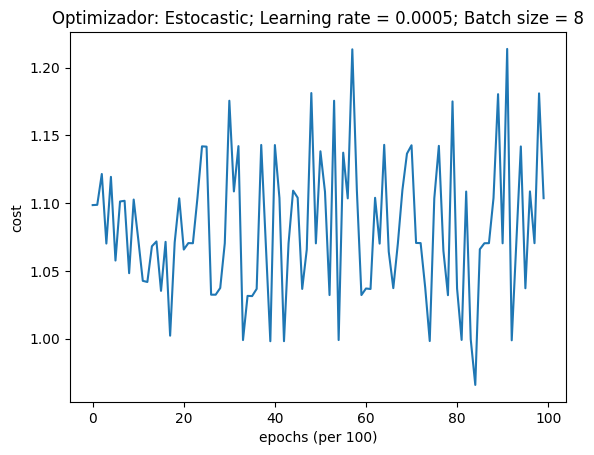

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098587
Costo tras epoch 1000: 1.100430
Costo tras epoch 2000: 1.102820
Costo tras epoch 3000: 1.035032
Costo tras epoch 4000: 1.107329
Costo tras epoch 5000: 1.067789
Costo tras epoch 6000: 0.997440
Costo tras epoch 7000: 1.180197
Costo tras epoch 8000: 1.031925
Costo tras epoch 9000: 1.032006


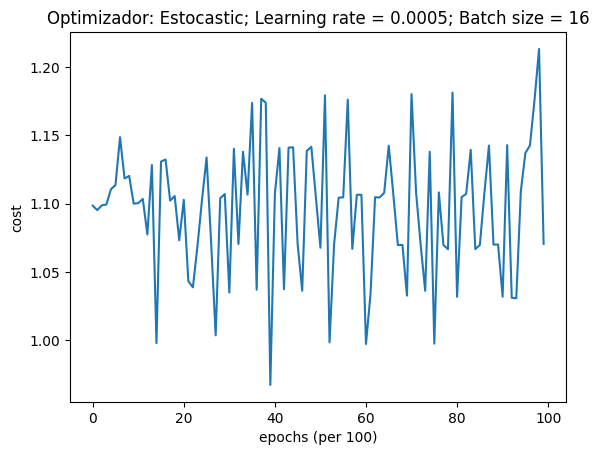

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098650
Costo tras epoch 1000: 1.088472
Costo tras epoch 2000: 1.083129
Costo tras epoch 3000: 1.108218
Costo tras epoch 4000: 1.060686
Costo tras epoch 5000: 1.078807
Costo tras epoch 6000: 1.077216
Costo tras epoch 7000: 1.036707
Costo tras epoch 8000: 1.098824
Costo tras epoch 9000: 1.098058


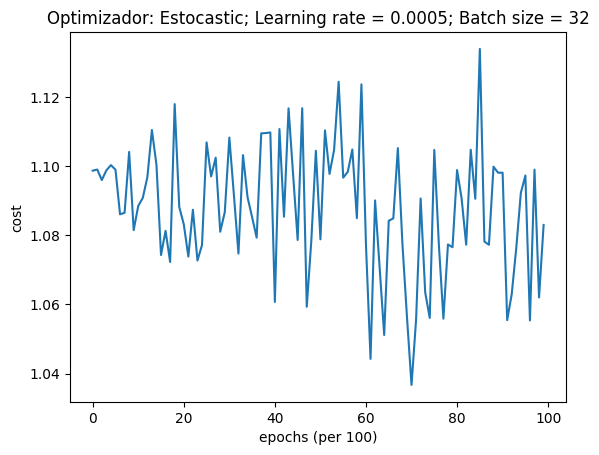

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098631
Costo tras epoch 1000: 1.088231
Costo tras epoch 2000: 1.063287
Costo tras epoch 3000: 1.125606
Costo tras epoch 4000: 1.020346
Costo tras epoch 5000: 1.100874
Costo tras epoch 6000: 0.978151
Costo tras epoch 7000: 1.103447
Costo tras epoch 8000: 1.067966
Costo tras epoch 9000: 1.139941


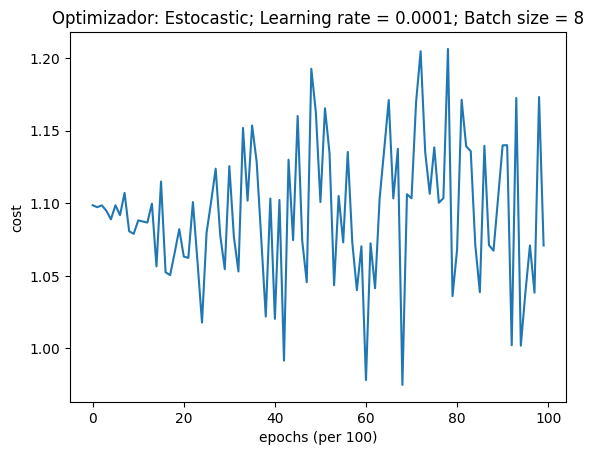

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 8 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098613
Costo tras epoch 1000: 1.092369
Costo tras epoch 2000: 1.099348
Costo tras epoch 3000: 1.132209
Costo tras epoch 4000: 1.041663
Costo tras epoch 5000: 1.033455
Costo tras epoch 6000: 1.052398
Costo tras epoch 7000: 1.102178
Costo tras epoch 8000: 1.073344
Costo tras epoch 9000: 1.043029


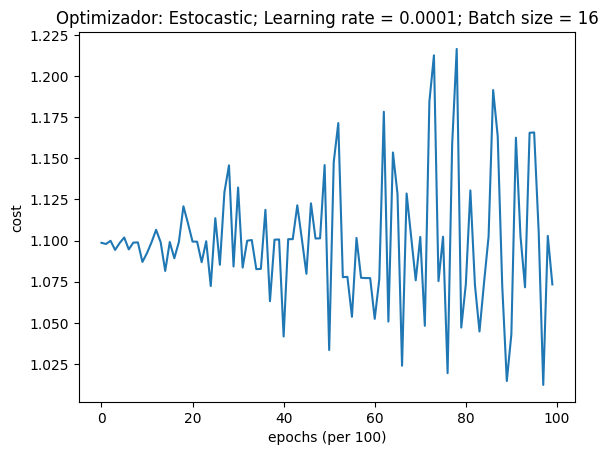

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 16 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 6, 3)
Costo tras epoch 0: 1.098611
Costo tras epoch 1000: 1.099354
Costo tras epoch 2000: 1.102723
Costo tras epoch 3000: 1.097187
Costo tras epoch 4000: 1.096992
Costo tras epoch 5000: 1.099611
Costo tras epoch 6000: 1.106257
Costo tras epoch 7000: 1.103897
Costo tras epoch 8000: 1.085001
Costo tras epoch 9000: 1.092583


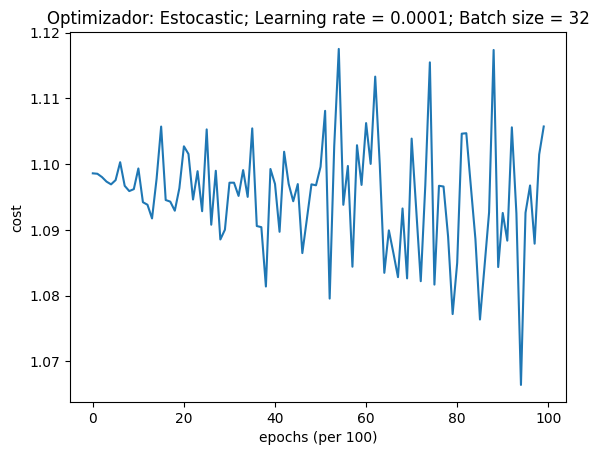

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 32 y estructura de capas (4, 16, 6, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.101973
Costo tras epoch 1000: 1.075966
Costo tras epoch 2000: 1.144079
Costo tras epoch 3000: 1.013816
Costo tras epoch 4000: 1.101528
Costo tras epoch 5000: 1.031346
Costo tras epoch 6000: 0.968147
Costo tras epoch 7000: 1.056271
Costo tras epoch 8000: 1.114678
Costo tras epoch 9000: 1.180336


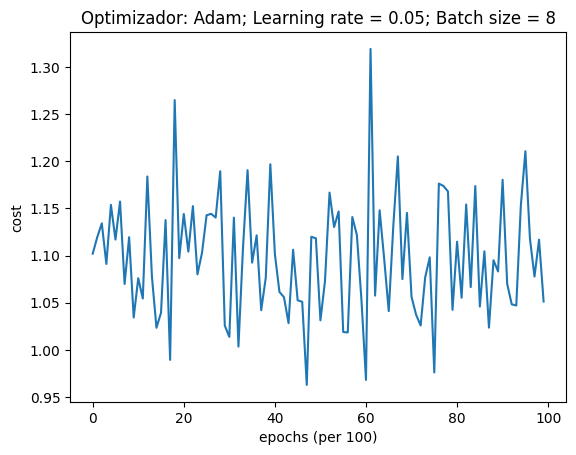

La exactitud para optimizador Adam con learning rate 0.05, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.848581
Costo tras epoch 1000: 1.075708
Costo tras epoch 2000: 1.066442
Costo tras epoch 3000: 1.033460
Costo tras epoch 4000: 1.105678
Costo tras epoch 5000: 1.017524
Costo tras epoch 6000: 1.158695
Costo tras epoch 7000: 1.062983
Costo tras epoch 8000: 1.020389
Costo tras epoch 9000: 1.079322


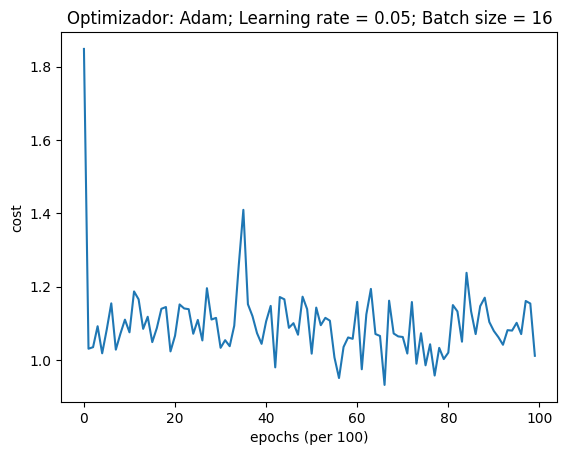

La exactitud para optimizador Adam con learning rate 0.05, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.05    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.235076
Costo tras epoch 1000: 0.435183
Costo tras epoch 2000: 0.510430
Costo tras epoch 3000: 0.415926
Costo tras epoch 4000: 0.451576
Costo tras epoch 5000: 0.345130
Costo tras epoch 6000: 0.494395
Costo tras epoch 7000: 0.465900
Costo tras epoch 8000: 0.519922
Costo tras epoch 9000: 0.496041


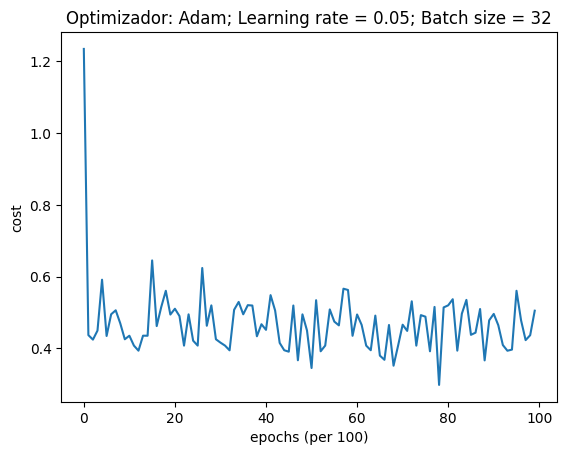

La exactitud para optimizador Adam con learning rate 0.05, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 66.666667 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.127996
Costo tras epoch 1000: 1.111897
Costo tras epoch 2000: 1.138144
Costo tras epoch 3000: 1.066656
Costo tras epoch 4000: 1.208158
Costo tras epoch 5000: 1.108121
Costo tras epoch 6000: 1.031975
Costo tras epoch 7000: 1.068017
Costo tras epoch 8000: 1.146623
Costo tras epoch 9000: 1.068212


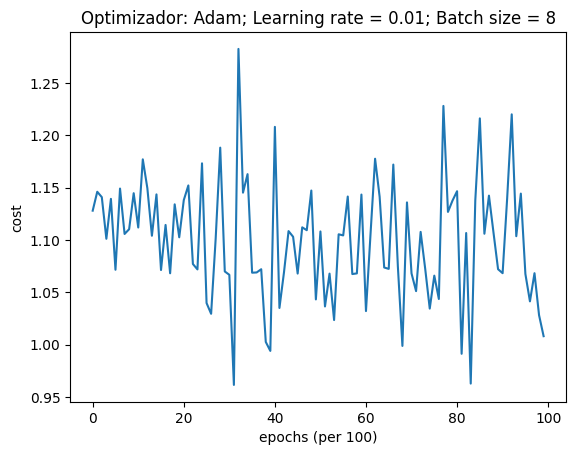

La exactitud para optimizador Adam con learning rate 0.01, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.240210
Costo tras epoch 1000: 1.039827
Costo tras epoch 2000: 1.112072
Costo tras epoch 3000: 1.093979
Costo tras epoch 4000: 0.977084
Costo tras epoch 5000: 1.075875
Costo tras epoch 6000: 1.102231
Costo tras epoch 7000: 1.169993
Costo tras epoch 8000: 1.048173
Costo tras epoch 9000: 1.097909


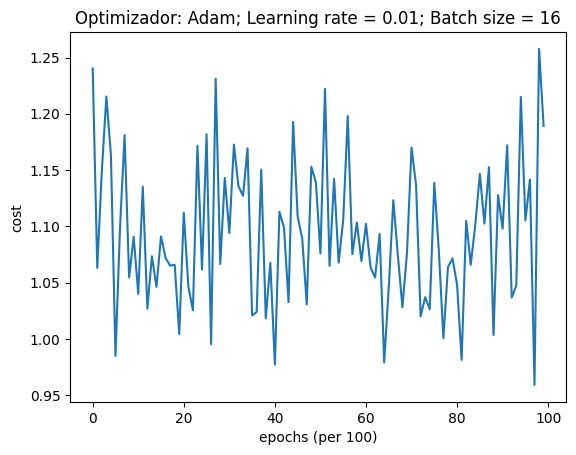

La exactitud para optimizador Adam con learning rate 0.01, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.01    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.088216
Costo tras epoch 1000: 1.041503
Costo tras epoch 2000: 1.064356
Costo tras epoch 3000: 1.070720
Costo tras epoch 4000: 1.063669
Costo tras epoch 5000: 1.097764
Costo tras epoch 6000: 1.061763
Costo tras epoch 7000: 1.084974
Costo tras epoch 8000: 1.113023
Costo tras epoch 9000: 1.054910


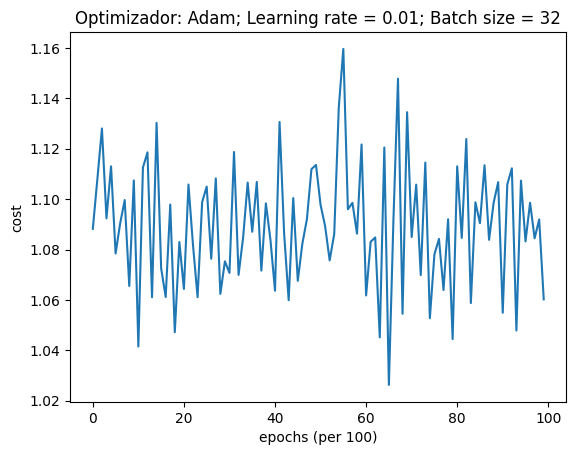

La exactitud para optimizador Adam con learning rate 0.01, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.126298
Costo tras epoch 1000: 1.069658
Costo tras epoch 2000: 1.145450
Costo tras epoch 3000: 1.198569
Costo tras epoch 4000: 1.101942
Costo tras epoch 5000: 1.069513
Costo tras epoch 6000: 1.141451
Costo tras epoch 7000: 1.144192
Costo tras epoch 8000: 1.028374
Costo tras epoch 9000: 1.105496


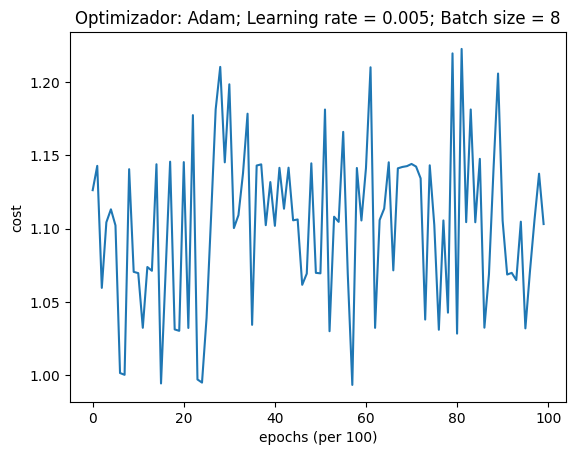

La exactitud para optimizador Adam con learning rate 0.005, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.144456
Costo tras epoch 1000: 0.991593
Costo tras epoch 2000: 1.070441
Costo tras epoch 3000: 1.137721
Costo tras epoch 4000: 1.196640
Costo tras epoch 5000: 1.043832
Costo tras epoch 6000: 1.043211
Costo tras epoch 7000: 1.067145
Costo tras epoch 8000: 1.151374
Costo tras epoch 9000: 1.186576


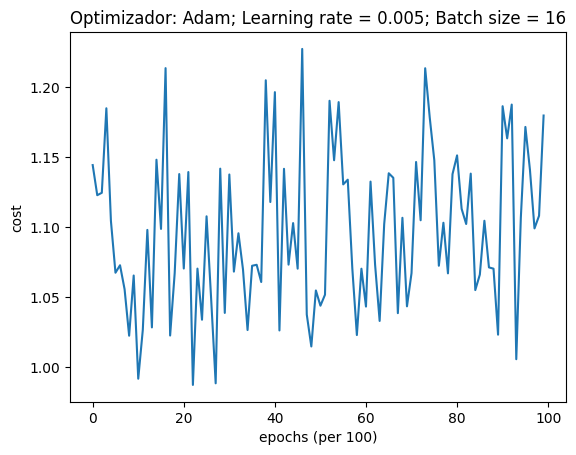

La exactitud para optimizador Adam con learning rate 0.005, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.146612
Costo tras epoch 1000: 0.000440
Costo tras epoch 2000: 0.000181
Costo tras epoch 3000: 0.000042
Costo tras epoch 4000: 0.000011
Costo tras epoch 5000: 0.000003
Costo tras epoch 6000: 0.000001
Costo tras epoch 7000: 0.000001
Costo tras epoch 8000: 0.000001
Costo tras epoch 9000: 0.000001


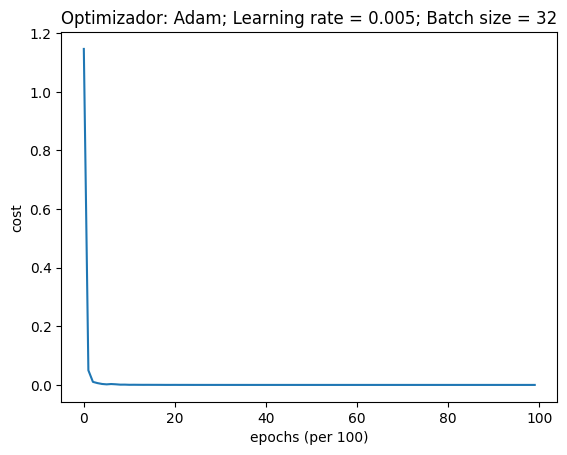

La exactitud para optimizador Adam con learning rate 0.005, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.091842
Costo tras epoch 1000: 0.999060
Costo tras epoch 2000: 1.068989
Costo tras epoch 3000: 1.141524
Costo tras epoch 4000: 0.995087
Costo tras epoch 5000: 1.109628
Costo tras epoch 6000: 1.108503
Costo tras epoch 7000: 1.069885
Costo tras epoch 8000: 1.107990
Costo tras epoch 9000: 1.103972


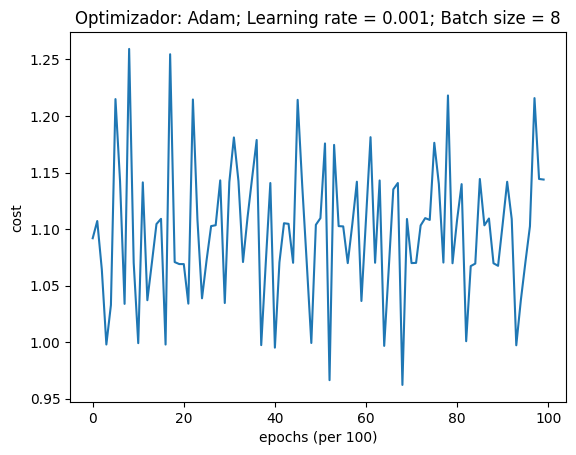

La exactitud para optimizador Adam con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.161392
Costo tras epoch 1000: 1.141460
Costo tras epoch 2000: 1.185839
Costo tras epoch 3000: 1.071284
Costo tras epoch 4000: 1.095341
Costo tras epoch 5000: 1.108203
Costo tras epoch 6000: 1.106067
Costo tras epoch 7000: 1.102120
Costo tras epoch 8000: 1.065174
Costo tras epoch 9000: 1.070223


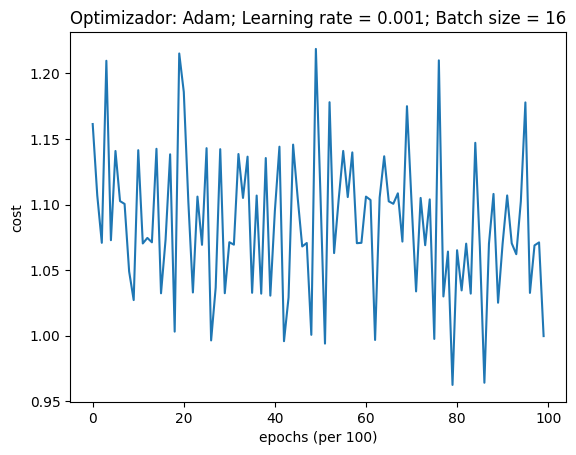

La exactitud para optimizador Adam con learning rate 0.001, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.097956
Costo tras epoch 1000: 1.129748
Costo tras epoch 2000: 1.133617
Costo tras epoch 3000: 1.048122
Costo tras epoch 4000: 1.105784
Costo tras epoch 5000: 1.112692
Costo tras epoch 6000: 1.088865
Costo tras epoch 7000: 1.069295
Costo tras epoch 8000: 1.089502
Costo tras epoch 9000: 1.069754


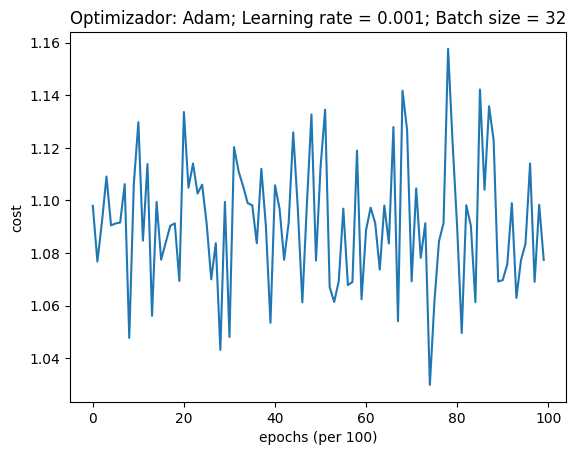

La exactitud para optimizador Adam con learning rate 0.001, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.131358
Costo tras epoch 1000: 0.013419
Costo tras epoch 2000: 0.000128
Costo tras epoch 3000: 0.000024
Costo tras epoch 4000: 0.000010
Costo tras epoch 5000: 0.000004
Costo tras epoch 6000: 0.000006
Costo tras epoch 7000: 0.000006
Costo tras epoch 8000: 0.000005
Costo tras epoch 9000: 0.000003


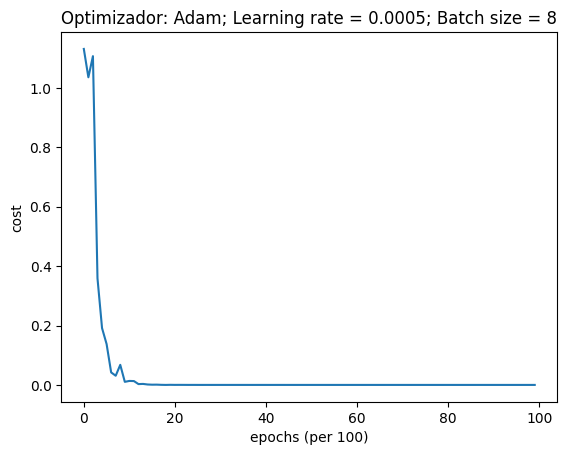

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.103622
Costo tras epoch 1000: 0.000877
Costo tras epoch 2000: 0.000000
Costo tras epoch 3000: -0.000000
Costo tras epoch 4000: -0.000000
Costo tras epoch 5000: -0.000000
Costo tras epoch 6000: -0.000000
Costo tras epoch 7000: -0.000000
Costo tras epoch 8000: -0.000000
Costo tras epoch 9000: -0.000000


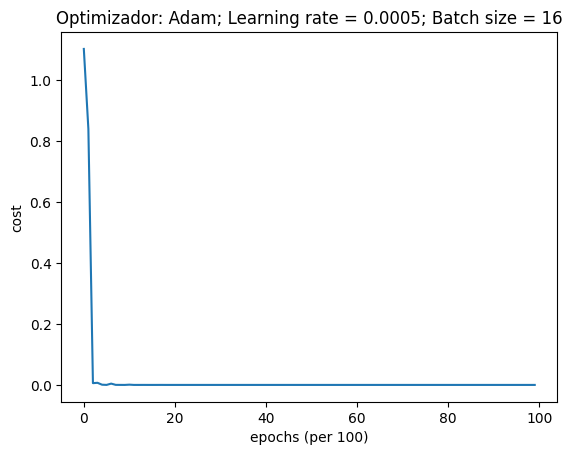

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.099910
Costo tras epoch 1000: 0.019005
Costo tras epoch 2000: 0.000307
Costo tras epoch 3000: 0.000049
Costo tras epoch 4000: 0.000002
Costo tras epoch 5000: 0.000001
Costo tras epoch 6000: 0.000001
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: 0.000000


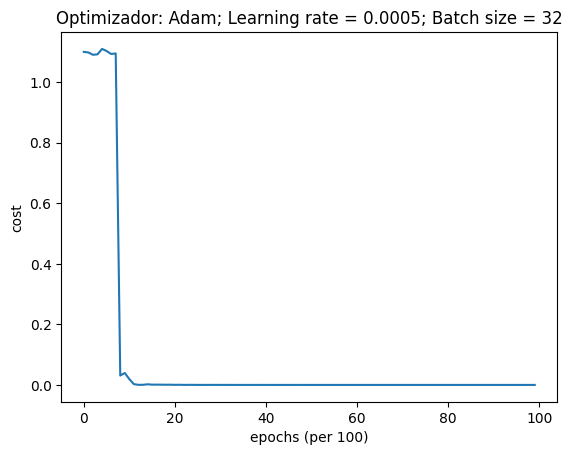

La exactitud para optimizador Adam con learning rate 0.0005, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.097101
Costo tras epoch 1000: 0.014159
Costo tras epoch 2000: 0.003731
Costo tras epoch 3000: 0.000307
Costo tras epoch 4000: 0.000001
Costo tras epoch 5000: 0.000000
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000000
Costo tras epoch 8000: 0.000000
Costo tras epoch 9000: -0.000000


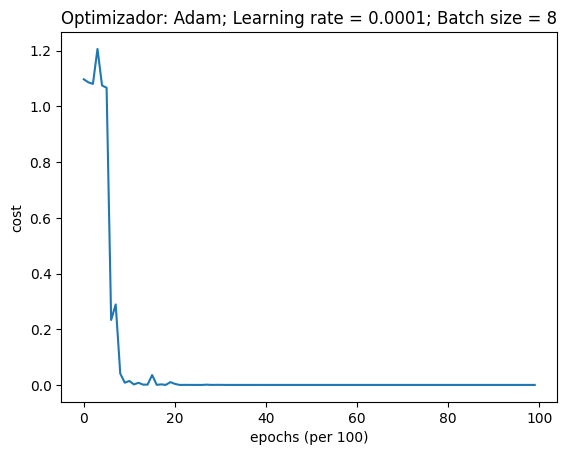

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.094369
Costo tras epoch 1000: 0.291956
Costo tras epoch 2000: 0.000134
Costo tras epoch 3000: 0.000107
Costo tras epoch 4000: 0.000003
Costo tras epoch 5000: 0.000082
Costo tras epoch 6000: 0.000000
Costo tras epoch 7000: 0.000002
Costo tras epoch 8000: 0.000002
Costo tras epoch 9000: 0.000000


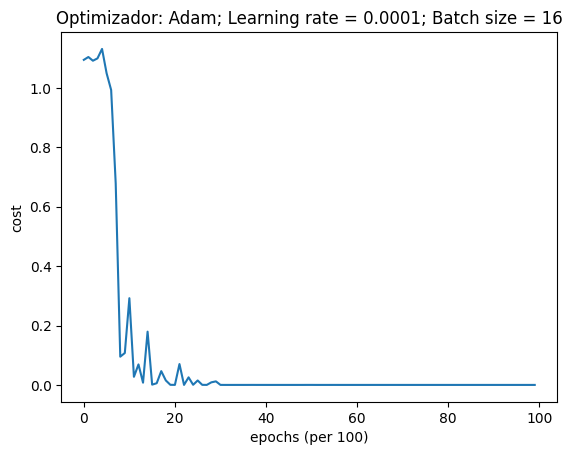

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Adam    LEARNING_RATE: 0.0001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.097316
Costo tras epoch 1000: 1.128874
Costo tras epoch 2000: 1.112263
Costo tras epoch 3000: 0.048489
Costo tras epoch 4000: 0.033328
Costo tras epoch 5000: 0.011238
Costo tras epoch 6000: 0.000961
Costo tras epoch 7000: 0.001172
Costo tras epoch 8000: 0.000036
Costo tras epoch 9000: 0.000037


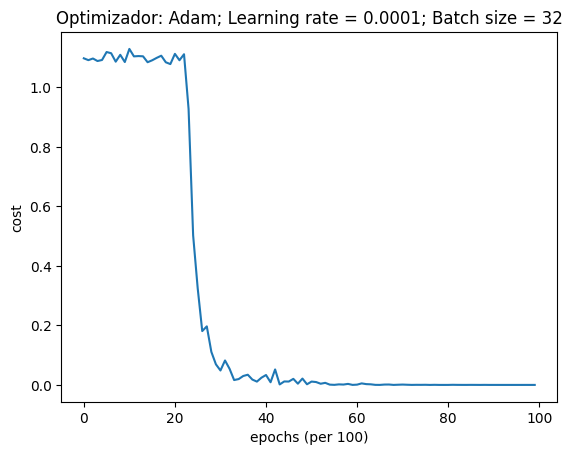

La exactitud para optimizador Adam con learning rate 0.0001, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 95.238095 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.103127
Costo tras epoch 1000: 1.113298
Costo tras epoch 2000: 1.180209
Costo tras epoch 3000: 1.141642
Costo tras epoch 4000: 1.075874
Costo tras epoch 5000: 0.999299
Costo tras epoch 6000: 1.043486
Costo tras epoch 7000: 1.072507
Costo tras epoch 8000: 1.031641
Costo tras epoch 9000: 1.140507


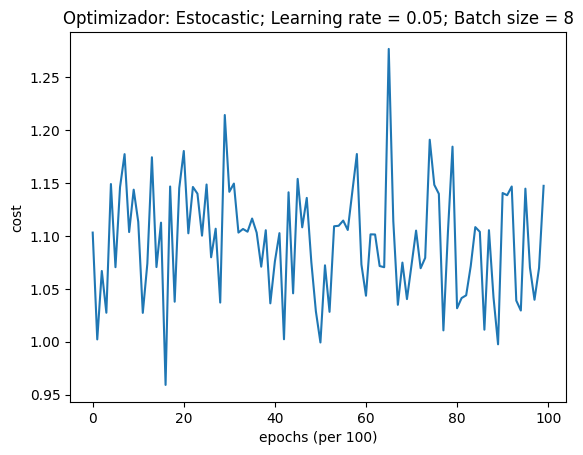

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.100705
Costo tras epoch 1000: 0.962118
Costo tras epoch 2000: 1.129712
Costo tras epoch 3000: 1.002737
Costo tras epoch 4000: 1.151835
Costo tras epoch 5000: 0.990756
Costo tras epoch 6000: 1.076784
Costo tras epoch 7000: 1.074838
Costo tras epoch 8000: 1.000855
Costo tras epoch 9000: 1.149531


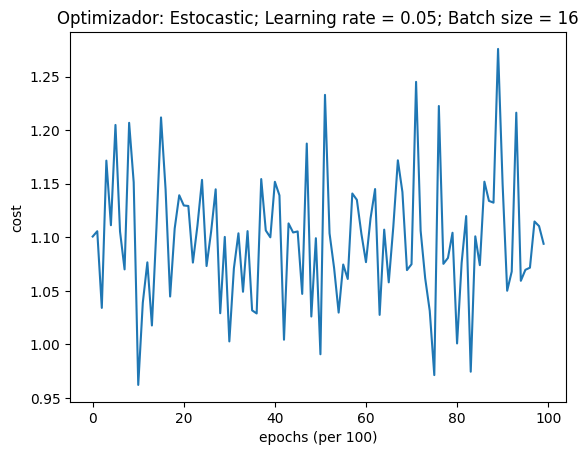

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.05    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098989
Costo tras epoch 1000: 1.127145
Costo tras epoch 2000: 1.070726
Costo tras epoch 3000: 1.098582
Costo tras epoch 4000: 1.127910
Costo tras epoch 5000: 1.124507
Costo tras epoch 6000: 1.056410
Costo tras epoch 7000: 1.128162
Costo tras epoch 8000: 1.113182
Costo tras epoch 9000: 1.098134


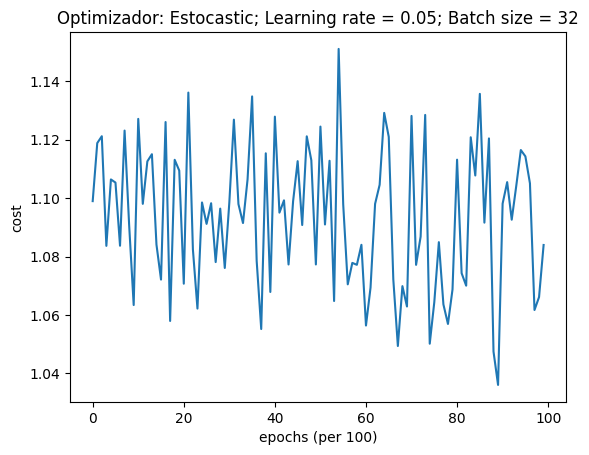

La exactitud para optimizador Estocastic con learning rate 0.05, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098819
Costo tras epoch 1000: 1.111708
Costo tras epoch 2000: 1.103883
Costo tras epoch 3000: 1.143841
Costo tras epoch 4000: 1.176455
Costo tras epoch 5000: 1.071109
Costo tras epoch 6000: 1.138544
Costo tras epoch 7000: 1.070306
Costo tras epoch 8000: 1.140526
Costo tras epoch 9000: 1.111485


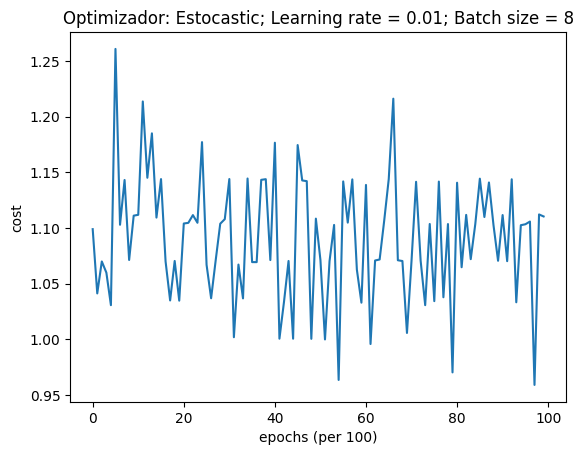

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.099025
Costo tras epoch 1000: 1.254159
Costo tras epoch 2000: 1.102645
Costo tras epoch 3000: 1.144210
Costo tras epoch 4000: 1.105831
Costo tras epoch 5000: 1.170852
Costo tras epoch 6000: 1.070343
Costo tras epoch 7000: 1.171916
Costo tras epoch 8000: 1.138270
Costo tras epoch 9000: 1.178917


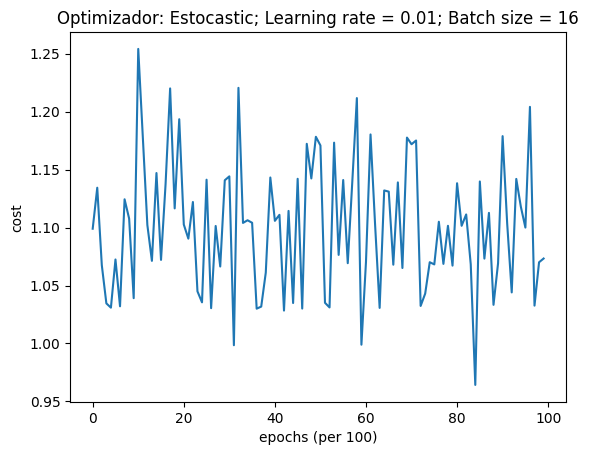

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.01    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098874
Costo tras epoch 1000: 1.093400
Costo tras epoch 2000: 1.098840
Costo tras epoch 3000: 1.070813
Costo tras epoch 4000: 1.126662
Costo tras epoch 5000: 1.134253
Costo tras epoch 6000: 1.104387
Costo tras epoch 7000: 1.048569
Costo tras epoch 8000: 1.069845
Costo tras epoch 9000: 1.076362


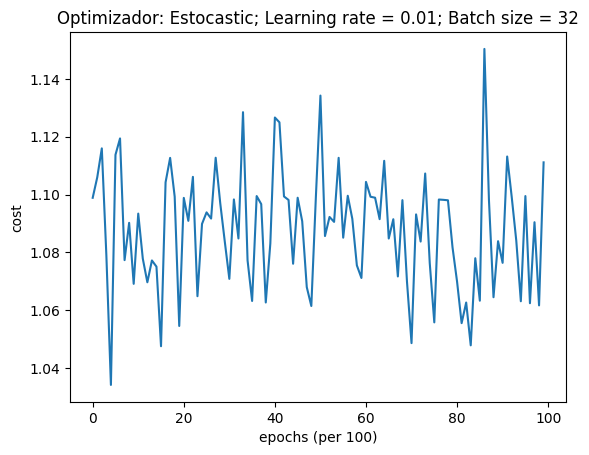

La exactitud para optimizador Estocastic con learning rate 0.01, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.097782
Costo tras epoch 1000: 1.036967
Costo tras epoch 2000: 1.216165
Costo tras epoch 3000: 1.141287
Costo tras epoch 4000: 1.141227
Costo tras epoch 5000: 1.103289
Costo tras epoch 6000: 1.070379
Costo tras epoch 7000: 1.070014
Costo tras epoch 8000: 1.033783
Costo tras epoch 9000: 1.040053


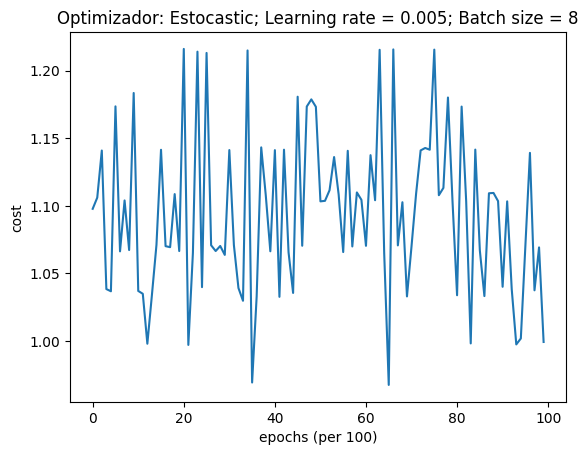

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098976
Costo tras epoch 1000: 1.142384
Costo tras epoch 2000: 1.001497
Costo tras epoch 3000: 1.180549
Costo tras epoch 4000: 1.068034
Costo tras epoch 5000: 1.212504
Costo tras epoch 6000: 1.180431
Costo tras epoch 7000: 1.107990
Costo tras epoch 8000: 1.030005
Costo tras epoch 9000: 1.069099


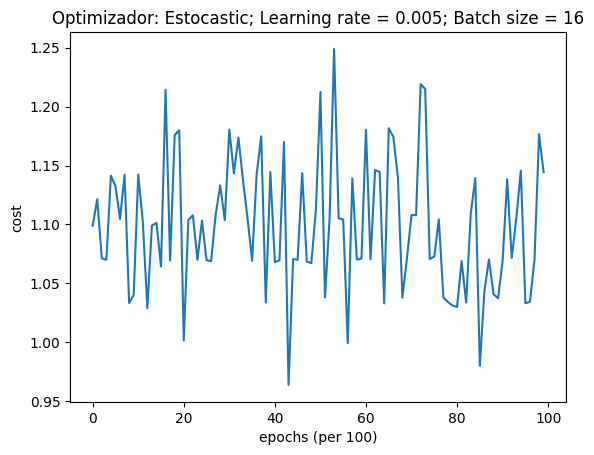

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098571
Costo tras epoch 1000: 1.091578
Costo tras epoch 2000: 1.106970
Costo tras epoch 3000: 1.061822
Costo tras epoch 4000: 1.134495
Costo tras epoch 5000: 1.091382
Costo tras epoch 6000: 1.092624
Costo tras epoch 7000: 1.069967
Costo tras epoch 8000: 1.112904
Costo tras epoch 9000: 1.082754


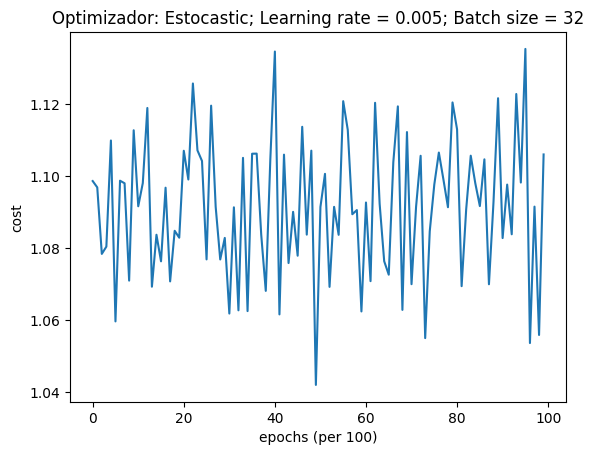

La exactitud para optimizador Estocastic con learning rate 0.005, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098696
Costo tras epoch 1000: 1.071197
Costo tras epoch 2000: 1.137876
Costo tras epoch 3000: 1.174093
Costo tras epoch 4000: 1.142522
Costo tras epoch 5000: 1.065491
Costo tras epoch 6000: 1.065488
Costo tras epoch 7000: 1.103779
Costo tras epoch 8000: 1.103848
Costo tras epoch 9000: 0.999885


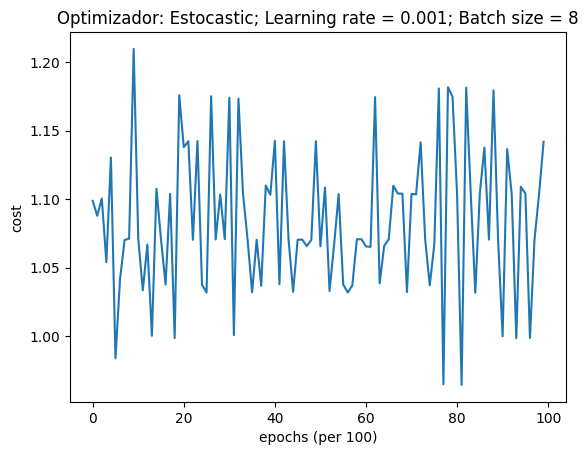

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098560
Costo tras epoch 1000: 1.104121
Costo tras epoch 2000: 1.172442
Costo tras epoch 3000: 1.103499
Costo tras epoch 4000: 1.032587
Costo tras epoch 5000: 1.070358
Costo tras epoch 6000: 1.070179
Costo tras epoch 7000: 1.141217
Costo tras epoch 8000: 1.176388
Costo tras epoch 9000: 1.032718


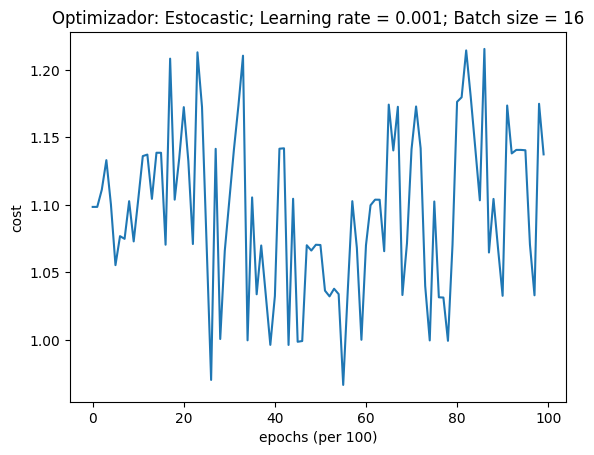

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098620
Costo tras epoch 1000: 1.083202
Costo tras epoch 2000: 1.090949
Costo tras epoch 3000: 1.138316
Costo tras epoch 4000: 1.098812
Costo tras epoch 5000: 1.069564
Costo tras epoch 6000: 1.140663
Costo tras epoch 7000: 1.099149
Costo tras epoch 8000: 1.105822
Costo tras epoch 9000: 1.092329


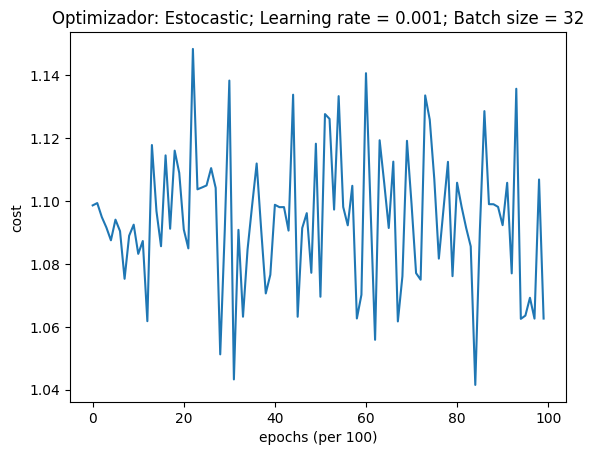

La exactitud para optimizador Estocastic con learning rate 0.001, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098560
Costo tras epoch 1000: 1.073650
Costo tras epoch 2000: 1.140772
Costo tras epoch 3000: 1.031864
Costo tras epoch 4000: 1.214884
Costo tras epoch 5000: 1.098342
Costo tras epoch 6000: 1.031903
Costo tras epoch 7000: 1.103876
Costo tras epoch 8000: 1.103499
Costo tras epoch 9000: 1.143149


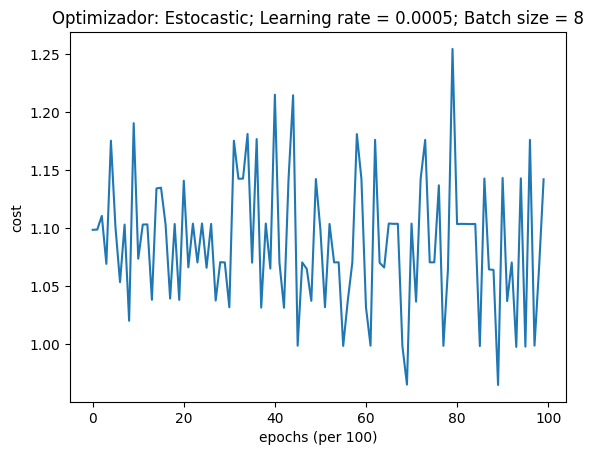

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098617
Costo tras epoch 1000: 1.032996
Costo tras epoch 2000: 1.102556
Costo tras epoch 3000: 1.003583
Costo tras epoch 4000: 1.211127
Costo tras epoch 5000: 1.103473
Costo tras epoch 6000: 1.037583
Costo tras epoch 7000: 1.107869
Costo tras epoch 8000: 0.967708
Costo tras epoch 9000: 1.142108


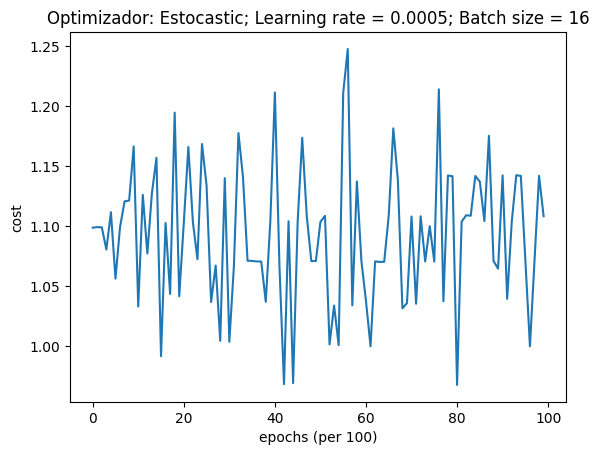

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0005    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098621
Costo tras epoch 1000: 1.085620
Costo tras epoch 2000: 1.087647
Costo tras epoch 3000: 1.097113
Costo tras epoch 4000: 1.097926
Costo tras epoch 5000: 1.077696
Costo tras epoch 6000: 1.098517
Costo tras epoch 7000: 1.084740
Costo tras epoch 8000: 1.076464
Costo tras epoch 9000: 1.098104


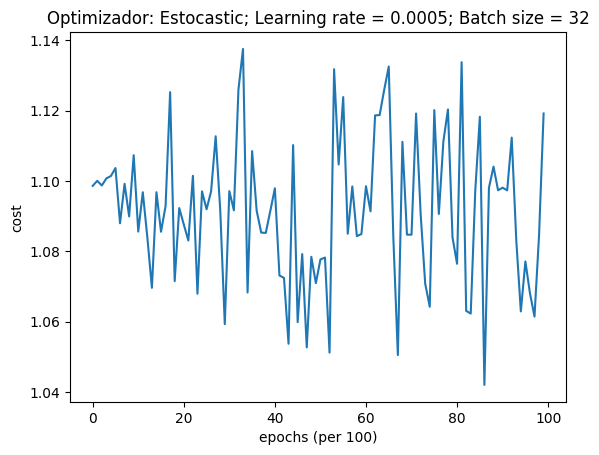

La exactitud para optimizador Estocastic con learning rate 0.0005, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 8    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098589
Costo tras epoch 1000: 1.099322
Costo tras epoch 2000: 1.119061
Costo tras epoch 3000: 1.102017
Costo tras epoch 4000: 1.020157
Costo tras epoch 5000: 1.073504
Costo tras epoch 6000: 1.008546
Costo tras epoch 7000: 1.039815
Costo tras epoch 8000: 1.139240
Costo tras epoch 9000: 1.140294


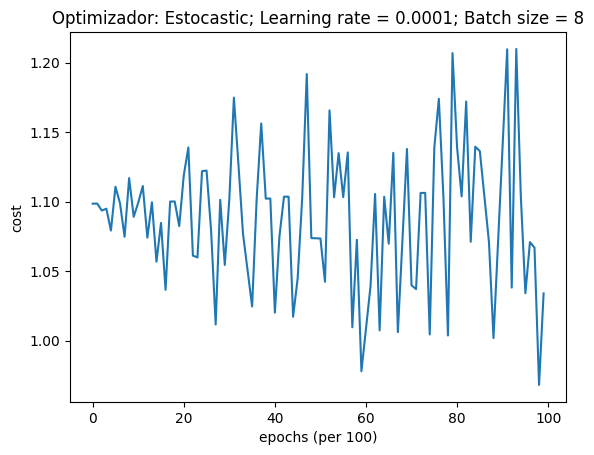

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 8 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 16    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098613
Costo tras epoch 1000: 1.092374
Costo tras epoch 2000: 1.122914
Costo tras epoch 3000: 1.148053
Costo tras epoch 4000: 1.041810
Costo tras epoch 5000: 1.101277
Costo tras epoch 6000: 1.151861
Costo tras epoch 7000: 1.075806
Costo tras epoch 8000: 1.074718
Costo tras epoch 9000: 1.131634


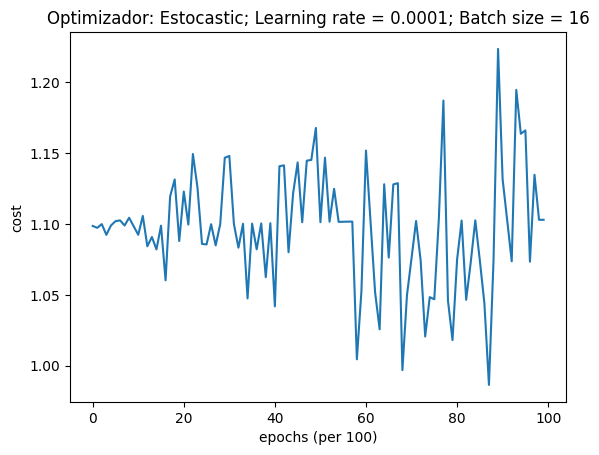

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 16 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

------------------------

OPTIMIZADOR: Estocastic    LEARNING_RATE: 0.0001    Nº BATCHES: 32    ESTRUCTURA CAPAS: (4, 16, 18, 16, 8, 3)
Costo tras epoch 0: 1.098612
Costo tras epoch 1000: 1.095948
Costo tras epoch 2000: 1.096254
Costo tras epoch 3000: 1.091571
Costo tras epoch 4000: 1.101739
Costo tras epoch 5000: 1.105323
Costo tras epoch 6000: 1.100000
Costo tras epoch 7000: 1.100330
Costo tras epoch 8000: 1.096663
Costo tras epoch 9000: 1.118080


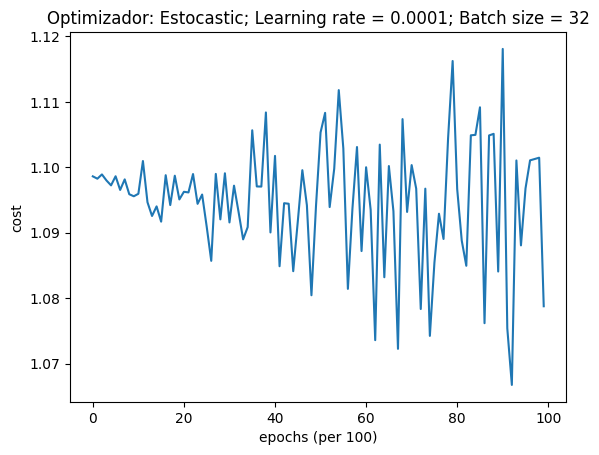

La exactitud para optimizador Estocastic con learning rate 0.0001, nº batches 32 y estructura de capas (4, 16, 18, 16, 8, 3)
es de: 47.619048 %
------------------------

Claves ordenadas según el tamaño del valor:
('Estocastic', 0.001, 8, (4, 16, 6, 3)): 1.0000
('Adam', 0.01, 16, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.005, 32, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.001, 8, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.001, 32, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.0005, 8, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.0005, 16, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.0005, 32, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.0001, 8, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.0001, 16, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.0001, 32, (4, 16, 12, 8, 3)): 0.9524
('Estocastic', 0.05, 32, (4, 16, 12, 8, 3)): 0.9524
('Adam', 0.005, 16, (4, 16, 6, 3)): 0.9524
('Adam', 0.001, 8, (4, 16, 6, 3)): 0.9524
('Adam', 0.001, 16, (4, 16, 6, 3)): 0.9524
('Adam', 0.001, 32, (4, 16, 6, 3)): 0.9524
('Adam', 0.0005, 8, (4, 16, 6, 3)): 0.9524


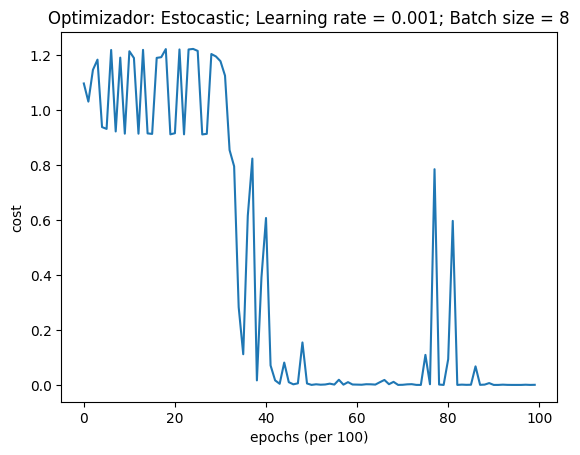

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


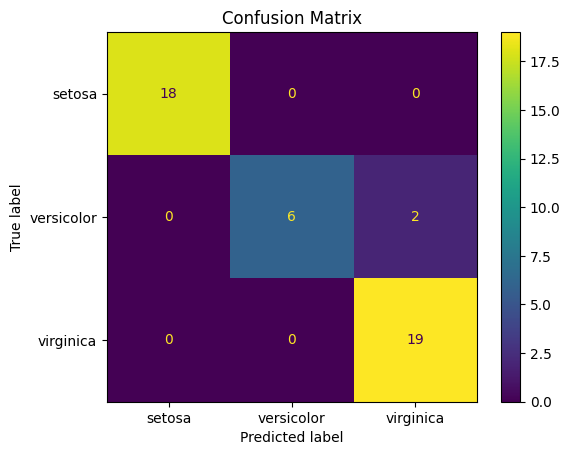

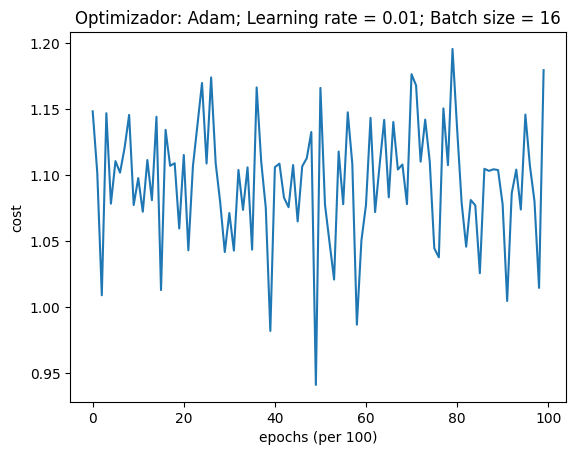

------------------------


Las predicciones son: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
La exactitud es de: 17.78 %


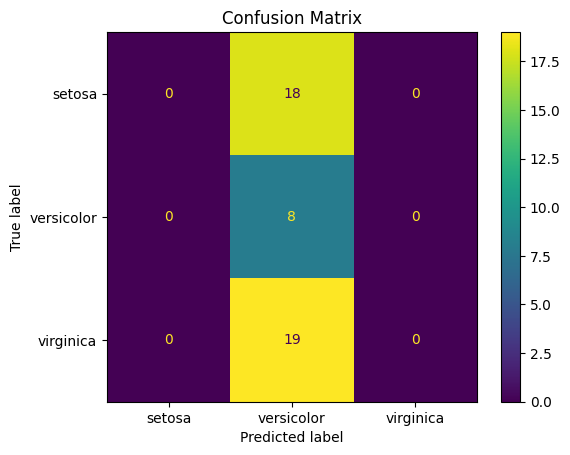

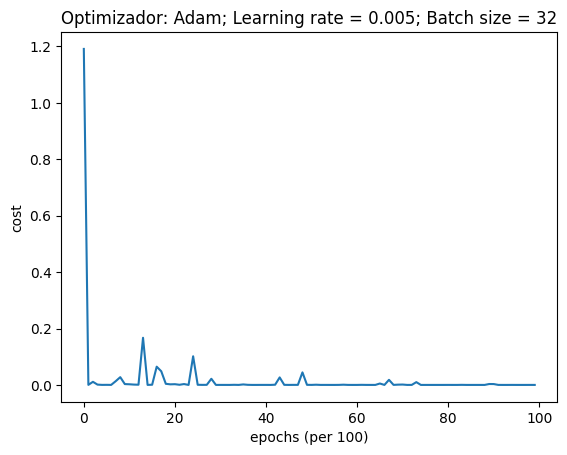

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


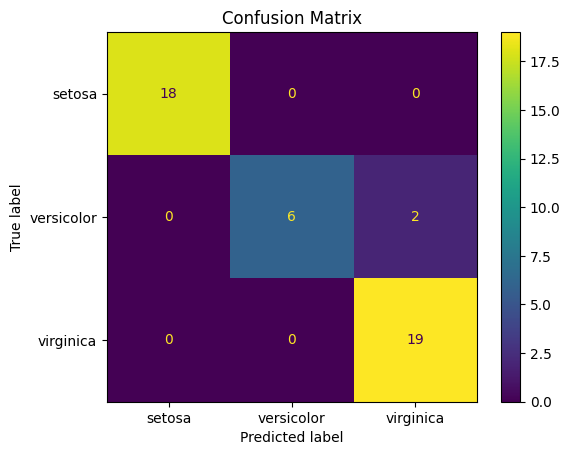

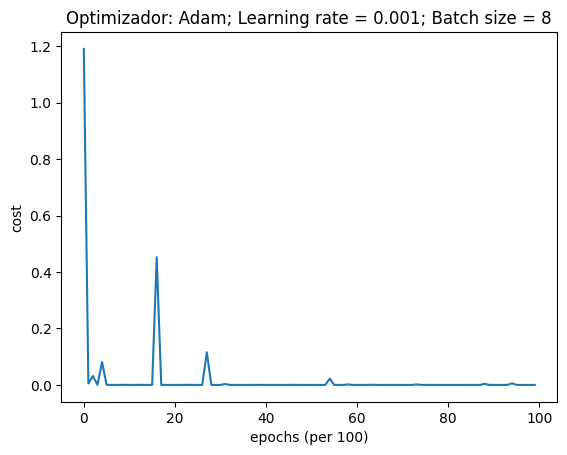

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


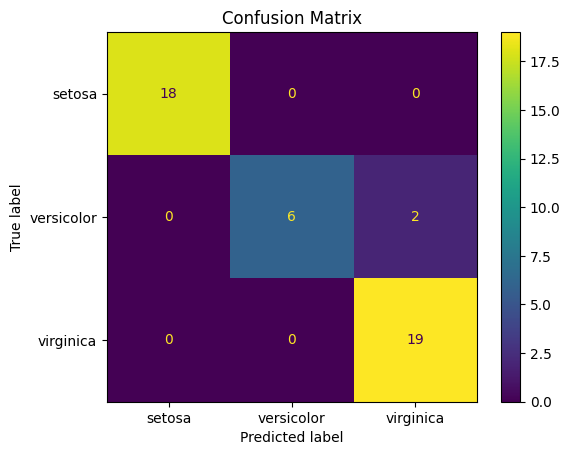

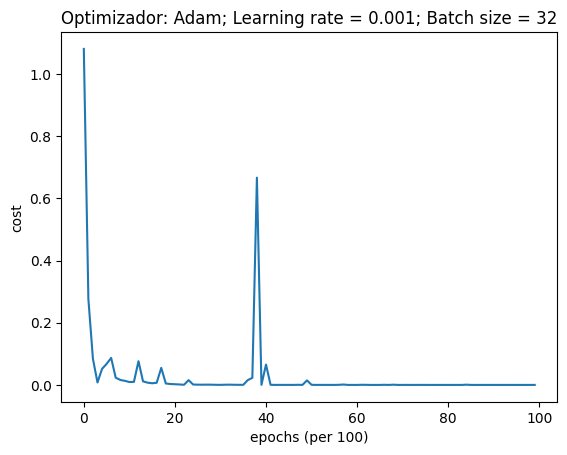

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


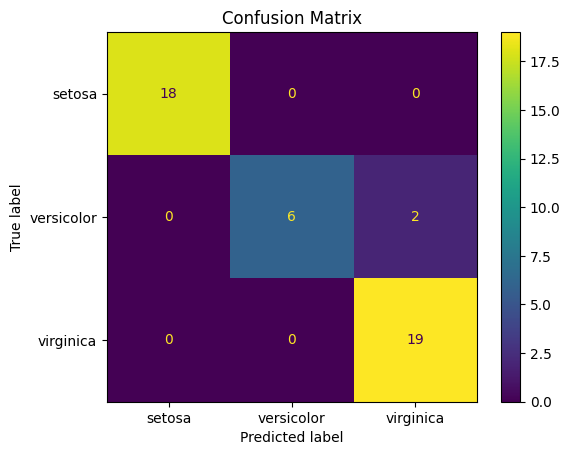

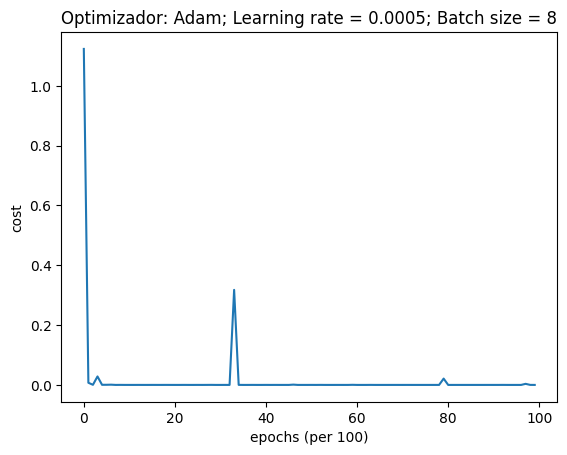

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


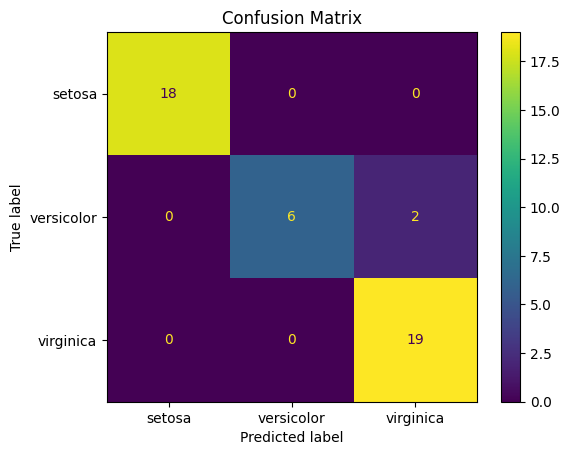

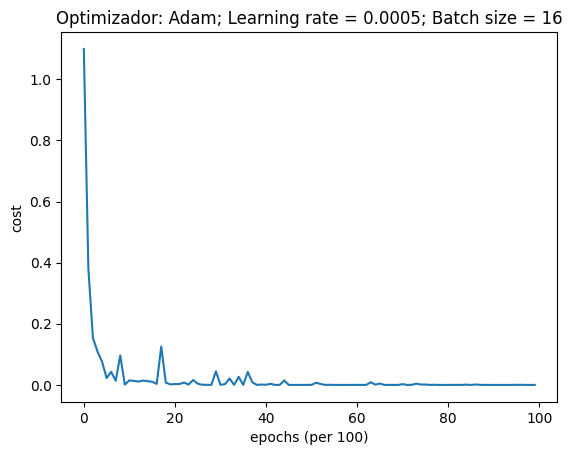

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


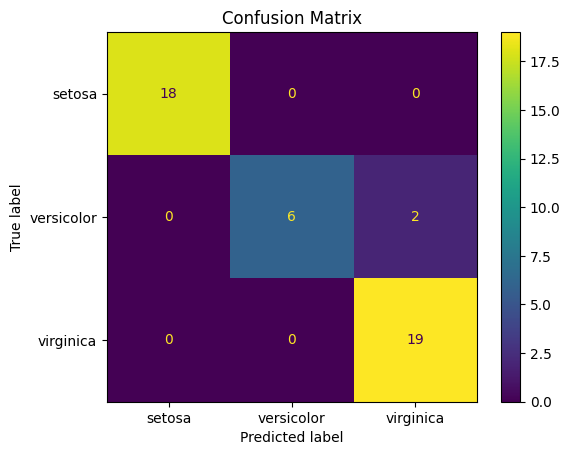

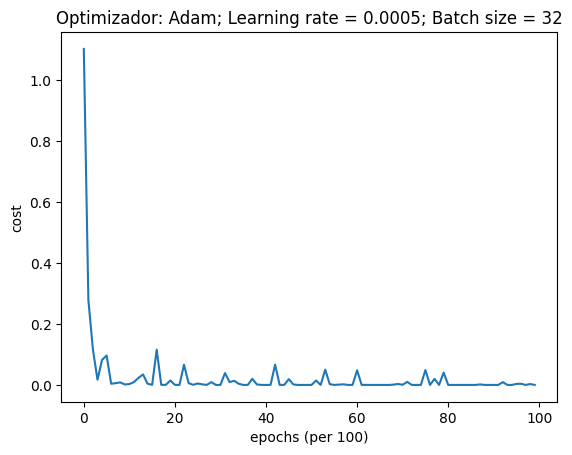

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


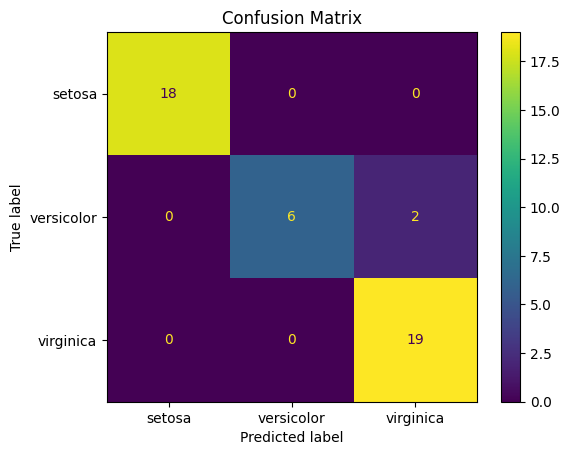

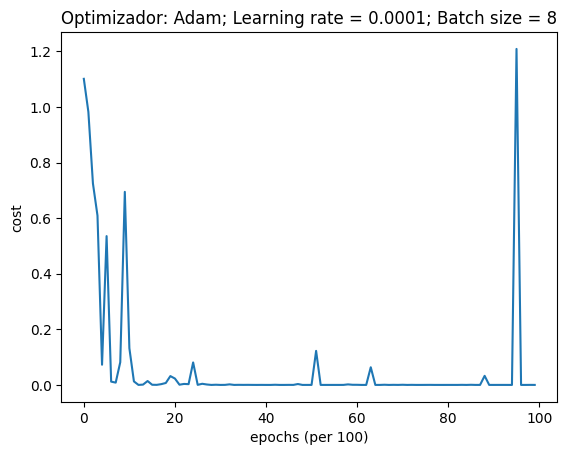

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


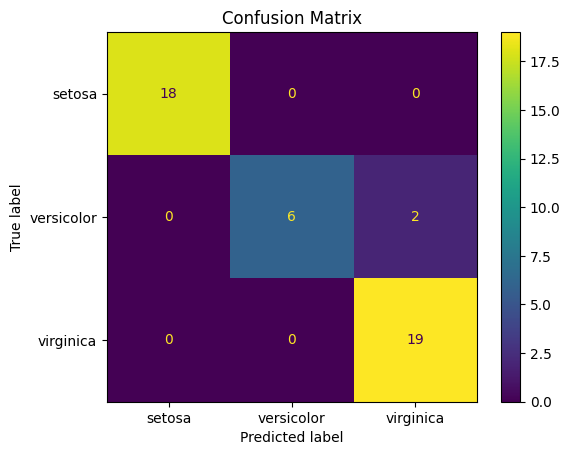

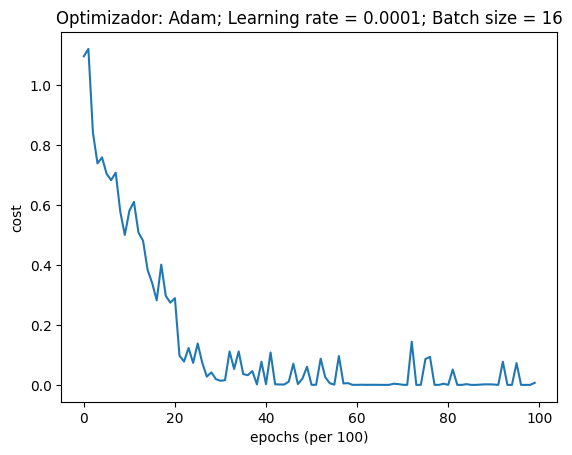

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


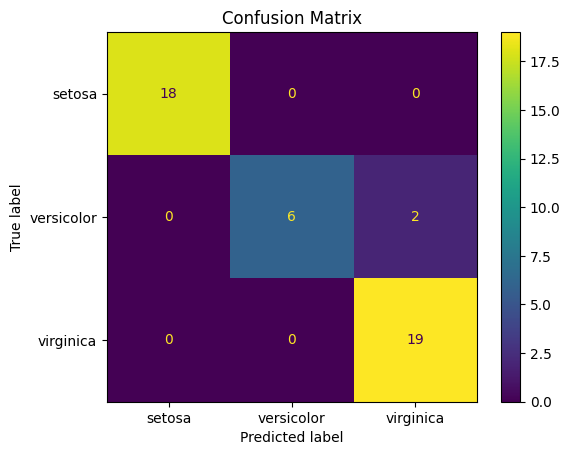

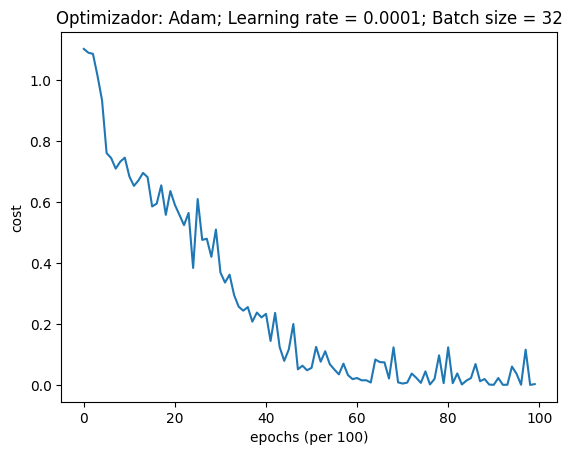

------------------------


Las predicciones son: [2 0 2 0 0 0 2 0 0 1 0 2 2 2 2 2 2 0 2 0 2 2 2 1 1 2 0 2 0 2 0 1 0 0 2 2 1
 0 0 0 1 2 0 2 2]
La exactitud es de: 95.56 %


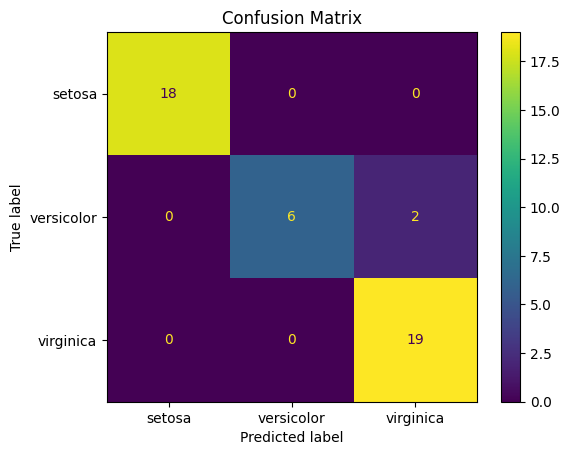

In [15]:
from itertools import product

def initialize_data():
    iris = load_iris()
    X = iris.data
    y = iris.target.reshape(-1, 1)

    graficar_TSNE(X, y, iris)

    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=156477)
    X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=15477)

    return X_train, X_test, y_train, y_test, X_train_2, X_val, y_train_2, y_val

def model_train_and_validation(layers_dims, learning_rates, batches, X_train_2, X_val, y_train_2, y_val):

    optimizers = ['Adam', 'Estocastic']
    resultados = {}

    combinaciones = product(layers_dims, optimizers, learning_rates, batches)

    for layer_dim, optimizer, learning_rate, batch in combinaciones:
        print(f'------------------------\n')
        print(f'OPTIMIZADOR: {optimizer}    LEARNING_RATE: {learning_rate}    Nº BATCHES: {batch}    ESTRUCTURA CAPAS: {layer_dim}')
        parameters = model(
            X_train_2, y_train_2, layer_dim,
            optimizer_use=optimizer,
            learning_rate=learning_rate,
            num_epochs=10000,
            batch_size=batch,
            print_cost=True
        )
        predictions, accuracy = predict(parameters, X_val, y_val)
        resultados[(optimizer, learning_rate, batch, layer_dim)] = accuracy
        print(f'La exactitud para optimizador {optimizer} con learning rate {learning_rate}, nº batches {batch} y estructura de capas {layer_dim}\nes de: {accuracy*100:.6f} %')
        print(f'------------------------\n')

    claves_ordenadas = sorted(resultados.keys(), key=lambda k: resultados[k], reverse=True)
    print("Claves ordenadas según el tamaño del valor:")
    for clave in claves_ordenadas:
        print(f"{clave}: {resultados[clave]:.4f}")

    return claves_ordenadas[:11]

def model_test(combination, X_train, X_test, y_train, y_test):
    parameters = model(
        X_train, y_train, combination[-1],
        optimizer_use=combination[0],
        learning_rate=combination[1],
        num_epochs=10000,
        batch_size=combination[2]
        )
    predictions, accuracy = predict(parameters, X_test, y_test)
    print(f'------------------------\n')
    print(f'\nLas predicciones son: {predictions}')
    print(f'La exactitud es de: {accuracy * 100:.2f} %')
    y_test_labels = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_labels, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=load_iris().target_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

X_train, X_test, y_train, y_test, X_train_2, X_val, y_train_2, y_val = initialize_data()
layers_dims = [(X_train_2.shape[1], 16, 12, 8, 3), (X_train_2.shape[1], 16, 6, 3), (X_train_2.shape[1], 16, 18, 16, 8, 3)]
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
batches = [8, 16, 32]

combinations = model_train_and_validation(layers_dims, learning_rates, batches, X_train_2, X_val, y_train_2, y_val)
for combination in combinations:
    model_test(combination, X_train, X_test, y_train, y_test)